### Imports

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

### Creating Shor Encoding Circuit

This function encodes a single logical qubit into 9 physical qubits using the 9-qubit Shor code.

**Steps**:

The circuit will be drawn separately to show this process clearly.
- **Bit-Flip Encoding**: Entangle the logical qubit (\(q_0\)) with \(q_3\) and \(q_6\), then within each 3-qubit block (\(q_0, q_1, q_2\); \(q_3, q_4, q_5\); \(q_6, q_7, q_8\)), entangle the first qubit with the other two.\n
- **Phase-Flip Encoding**: Apply Hadamard gates to all qubits, then entangle the first qubits of each block (\(q_0, q_3, q_6\)).\n

In [2]:
def create_shor_encoding_circuit(qc, logical_qubit_index):
    # 1. Bit-flip encoding: Protect against bit-flip errors (3-qubit repetition code)
    qc.barrier(label='Start Bit-Flip Encoding')
    # Copy q[0] to q[3] and q[6]
    qc.cx(logical_qubit_index, 3)
    qc.cx(logical_qubit_index, 6)

    # Within each block, create the 3-qubit repetition code
    # Block 1: qubits 0, 1, 2
    qc.cx(0, 1)
    qc.cx(0, 2)
    # Block 2: qubits 3, 4, 5
    qc.cx(3, 4)
    qc.cx(3, 5)
    # Block 3: qubits 6, 7, 8
    qc.cx(6, 7)
    qc.cx(6, 8)
    qc.barrier(label='End Bit-Flip Encoding')

    # 2. Phase-flip encoding: Protect against phase-flip errors
    qc.barrier(label='Start Phase-Flip Encoding')
    # Apply Hadamards to all qubits to transform to phase basis
    for i in range(9):
        qc.h(i)
    # Entangle first qubits of each block to create phase-flip code
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.barrier(label='End Phase-Flip Encoding')

### Introduce Error

This function introduces a single error (bit-flip, phase-flip, or both) on one of the 9 qubits to test the code’s error correction capability.

In [3]:
def introduce_error(qc, qubit_index, error_type='bit_flip'):
    if not (0 <= qubit_index <= 8):
        print(f"Warning: Error introduced on non-data qubit {qubit_index}. Skipping error.")
        return

    qc.barrier(label=f'Start Error ({error_type} on q{qubit_index})')
    if error_type == 'bit_flip':
        print(f"  Introducing a BIT-FLIP error on qubit {qubit_index}")
        qc.x(qubit_index)
    elif error_type == 'phase_flip':
        print(f"  Introducing a PHASE-FLIP error on qubit {qubit_index}")
        qc.z(qubit_index)
    elif error_type == 'bit_and_phase_flip':
        print(f"  Introducing a BIT-AND-PHASE-FLIP error on qubit {qubit_index}")
        qc.y(qubit_index)
    else:
        print(f"  No error introduced. Unknown error type: {error_type}")
    qc.barrier(label=f'End Error')

### Detect and Correct Bit-Flip Errors

This function detects and corrects bit-flip errors within a 3-qubit block using 2 ancilla qubits.

**Steps**:

- Use CNOT gates to compare qubits within the block (e.g., \(q_0\) vs. \(q_1\), \(q_1\) vs. \(q_2\)).
- Measure the ancillas to get a syndrome.
- Apply an \(X\) gate to correct the error based on the syndrome.


In [4]:
def detect_and_correct_bit_flip(qc, data_q_start_index, syndrome_q_start_index, syndrome_c_start_index):
    qc.barrier(label=f'Bit-Flip Syndrome (q{data_q_start_index}-q{data_q_start_index+2})')
    # CNOTs to entangle data qubits with syndrome qubits
    qc.cx(data_q_start_index, syndrome_q_start_index)
    qc.cx(data_q_start_index+1, syndrome_q_start_index)
    qc.cx(data_q_start_index+1, syndrome_q_start_index+1)
    qc.cx(data_q_start_index+2, syndrome_q_start_index+1)

    # Measure syndrome qubits into classical bits
    qc.measure(syndrome_q_start_index, syndrome_c_start_index)
    qc.measure(syndrome_q_start_index+1, syndrome_c_start_index+1)

    # Apply corrections based on syndrome
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b1)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b0)):
            qc.x(data_q_start_index)
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b0)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b1)):
            qc.x(data_q_start_index+2)
    with qc.if_test((qc.clbits[syndrome_c_start_index], 0b1)):
        with qc.if_test((qc.clbits[syndrome_c_start_index+1], 0b1)):
            qc.x(data_q_start_index+1)

    # Reset syndrome qubits
    qc.reset(syndrome_q_start_index)
    qc.reset(syndrome_q_start_index+1)
    qc.barrier(label='End Bit-Flip Correction')

### Detect and Correct Phase-Flip Errors

This function detects and corrects phase-flip errors across the 9-qubit code.

**Steps**:
- Apply Hadamard gates to convert phase errors to bit errors.
- Perform bit-flip correction on each block.
- Revert the basis with Hadamard gates.
- Compare the first qubits of each block (\(q_0, q_3, q_6\)) to detect phase errors.
- Apply \(Z\) gates to correct phase errors.
- Revert the basis with Hadamard gates.

In [5]:
def detect_and_correct_phase_flip(qc, bit_flip_syndrome_q_start, bit_flip_syndrome_c_start,
                                 phase_flip_syndrome_q_start, phase_flip_syndrome_c_start):
    # Convert phase errors to bit errors
    qc.barrier(label='Convert Phase to Bit Errors')
    for q_idx in range(9):
        qc.h(q_idx)

    # Apply bit-flip detection/correction for each block
    detect_and_correct_bit_flip(qc, 0, bit_flip_syndrome_q_start, bit_flip_syndrome_c_start)
    detect_and_correct_bit_flip(qc, 3, bit_flip_syndrome_q_start+2, bit_flip_syndrome_c_start+2)
    detect_and_correct_bit_flip(qc, 6, bit_flip_syndrome_q_start+4, bit_flip_syndrome_c_start+4)

    # CNOTs to entangle first qubit of each block with phase syndrome qubits
    qc.barrier(label='Phase-Flip Syndrome')
    qc.cx(0, phase_flip_syndrome_q_start)
    qc.cx(3, phase_flip_syndrome_q_start)
    qc.cx(3, phase_flip_syndrome_q_start+1)
    qc.cx(6, phase_flip_syndrome_q_start+1)

    # Measure phase syndrome qubits
    qc.measure(phase_flip_syndrome_q_start, phase_flip_syndrome_c_start)
    qc.measure(phase_flip_syndrome_q_start+1, phase_flip_syndrome_c_start+1)

    # Apply corrections based on phase syndrome
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b1)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b0)):
            qc.z(0)
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b0)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b1)):
            qc.z(6)
    with qc.if_test((qc.clbits[phase_flip_syndrome_c_start], 0b1)):
        with qc.if_test((qc.clbits[phase_flip_syndrome_c_start+1], 0b1)):
            qc.z(3)

    # Reset phase syndrome qubits
    qc.reset(phase_flip_syndrome_q_start)
    qc.reset(phase_flip_syndrome_q_start+1)

    # Revert phase errors to phase-flips
    qc.barrier(label='Revert Basis')
    for q_idx in range(9):
        qc.h(q_idx)
    qc.barrier(label='End Phase-Flip Correction')

### Creating Shor Decoding Circuit

This function reverses the encoding process to recover the logical qubit.

**Steps**:
- Reverse the phase-flip encoding (undo CNOTs and Hadamards).
- Reverse the bit-flip encoding (undo CNOTs within blocks and between \(q_0, q_3, q_6\)).


In [6]:
def create_shor_decoding_circuit(qc, logical_qubit_index):
    # Reverse phase-flip encoding
    qc.barrier(label='Reverse Phase-Flip Encoding')
    qc.cx(0, 6)
    qc.cx(0, 3)
    for i in range(9):
        qc.h(i)

    # Reverse bit-flip encoding
    qc.barrier(label='Reverse Bit-Flip Encoding')
    qc.cx(6, 8)
    qc.cx(6, 7)
    qc.cx(3, 5)
    qc.cx(3, 4)
    qc.cx(0, 2)
    qc.cx(0, 1)
    qc.cx(logical_qubit_index, 6)
    qc.cx(logical_qubit_index, 3)
    qc.barrier(label='End Decoding')

### Shor Code Circuit with Explainable Diagrams

This function constructs the 9-qubit Shor code circuit in stages, drawing each part separately for clarity.

**Stages**:
1. **Encoding**: Show the bit-flip and phase-flip encoding.
2. **Error Introduction**: Introduce an error (if specified).
3. **Error Correction**: Show bit-flip and phase-flip correction.
4. **Decoding**: Reverse the encoding.
5. **Final Measurement**: Measure the logical qubit.

Each stage will be drawn as a separate circuit diagram with labels.

In [7]:
def shor_code_full_circuit(initial_state_qubit_index=0, error_qubit=None, error_type=None):
    TOTAL_Q_QUBITS = 17  # 9 data + 6 bit-flip ancillas + 2 phase-flip ancillas
    TOTAL_C_BITS = 9  # 6 bit-flip syndromes + 2 phase-flip syndromes + 1 logical measurement

    # Stage 1: Encoding
    print("\nStage 1: Encoding Circuit")
    encoding_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    create_shor_encoding_circuit(encoding_circuit, initial_state_qubit_index)
    fig = encoding_circuit.draw(output='mpl', scale=1.5, fold=-1)
    display(fig)
    plt.close(fig)

    # Stage 2: Error Introduction (if any)
    error_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    if error_qubit is not None and error_type is not None:
        print("\nStage 2: Error Introduction")
        introduce_error(error_circuit, error_qubit, error_type)
        fig = error_circuit.draw(output='mpl', scale=1.5, fold=-1)
        display(fig)
        plt.close(fig)

    # Stage 3: Error Detection and Correction
    print("\nStage 3: Error Detection and Correction")
    correction_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    Q_BIT_FLIP_ANC_START = 9
    C_BIT_FLIP_SYNDROME_START = 0
    Q_PHASE_FLIP_ANC_START = 15
    C_PHASE_FLIP_SYNDROME_START = 6
    detect_and_correct_phase_flip(correction_circuit,
                                 Q_BIT_FLIP_ANC_START, C_BIT_FLIP_SYNDROME_START,
                                 Q_PHASE_FLIP_ANC_START, C_PHASE_FLIP_SYNDROME_START)
    fig = correction_circuit.draw(output='mpl', scale=1.5, fold=-1)
    display(fig)
    plt.close(fig)

    # Stage 4: Decoding
    print("\nStage 4: Decoding Circuit")
    decoding_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    create_shor_decoding_circuit(decoding_circuit, initial_state_qubit_index)
    fig = decoding_circuit.draw(output='mpl', scale=1.5, fold=-1)
    display(fig)
    plt.close(fig)

    # Stage 5: Final Measurement
    print("\nStage 5: Final Measurement")
    measurement_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    C_LOGICAL_MEASUREMENT = 8
    measurement_circuit.measure(initial_state_qubit_index, C_LOGICAL_MEASUREMENT)
    fig = measurement_circuit.draw(output='mpl', scale=1.5, fold=-1)
    display(fig)
    plt.close(fig)

    # Combine all stages into the full circuit for simulation
    full_circuit = QuantumCircuit(TOTAL_Q_QUBITS, TOTAL_C_BITS)
    create_shor_encoding_circuit(full_circuit, initial_state_qubit_index)
    if error_qubit is not None and error_type is not None:
        introduce_error(full_circuit, error_qubit, error_type)
    detect_and_correct_phase_flip(full_circuit,
                                 Q_BIT_FLIP_ANC_START, C_BIT_FLIP_SYNDROME_START,
                                 Q_PHASE_FLIP_ANC_START, C_PHASE_FLIP_SYNDROME_START)
    create_shor_decoding_circuit(full_circuit, initial_state_qubit_index)
    full_circuit.measure(initial_state_qubit_index, C_LOGICAL_MEASUREMENT)

    return full_circuit

### Running Shor Simulation

This function runs the simulation and displays the results. The circuit diagrams are now shown in stages above, so we only need the simulation results here.

In [8]:
def run_shor_simulation(error_qubit=None, error_type=None):

    shor_circuit = shor_code_full_circuit(error_qubit=error_qubit, error_type=error_type)

    simulator = AerSimulator()
    compiled_circuit = transpile(shor_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(shor_circuit)

    print("\nMeasurement Results (Classical Bits, from LSB to MSB):")
    print(counts)

    logical_qubit_results = {}
    for outcome, count in counts.items():
        logical_qubit_state = outcome[0]
        logical_qubit_results[logical_qubit_state] = logical_qubit_results.get(logical_qubit_state, 0) + count

    print("\nDecoded Logical Qubit Measurement (from c[8]):")
    print(logical_qubit_results)

    initial_logical_state_counts = logical_qubit_results.get('0', 0)
    print(f"Success Rate (Ideal |0> state): {initial_logical_state_counts / 1024 * 100:.2f}%")
    if initial_logical_state_counts > 900:
        print("Shor code successfully corrected the error!")
    else:
        print("Shor code failed to correct the error.")

#### Simulation 1: BIT and Phase Flip Error on Qubit 7


Stage 1: Encoding Circuit


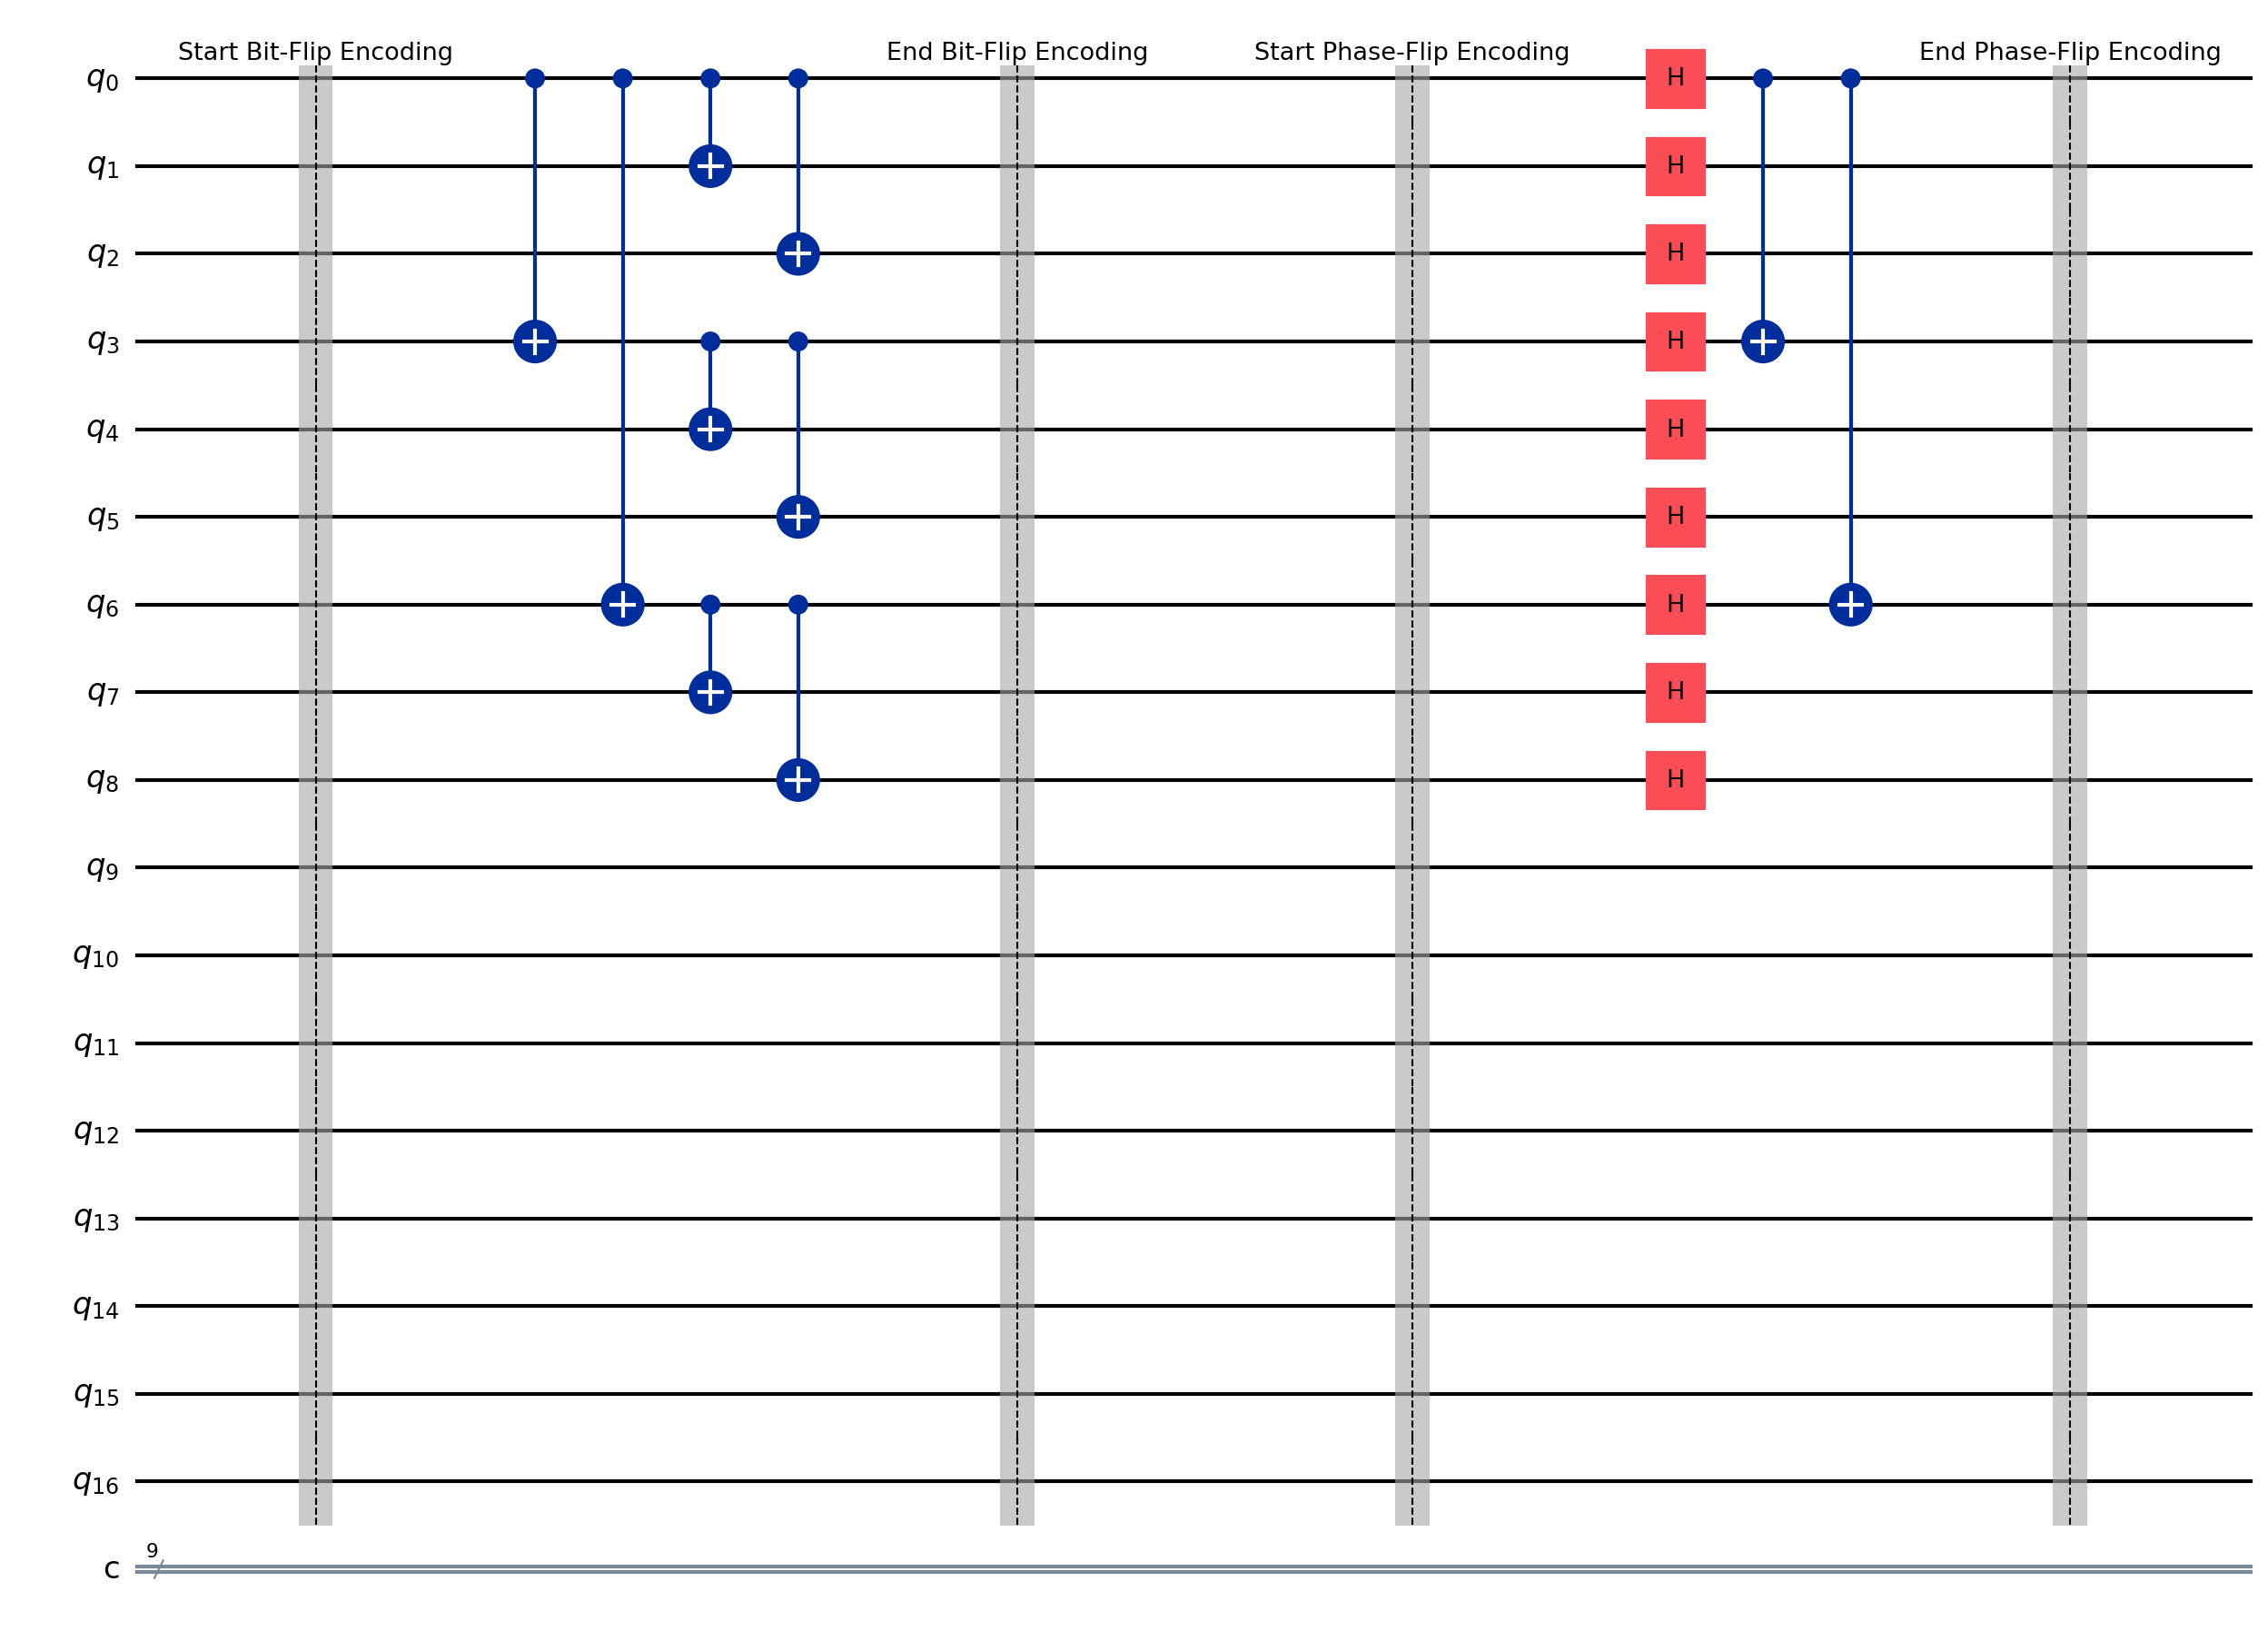


Stage 2: Error Introduction
  Introducing a BIT-AND-PHASE-FLIP error on qubit 7


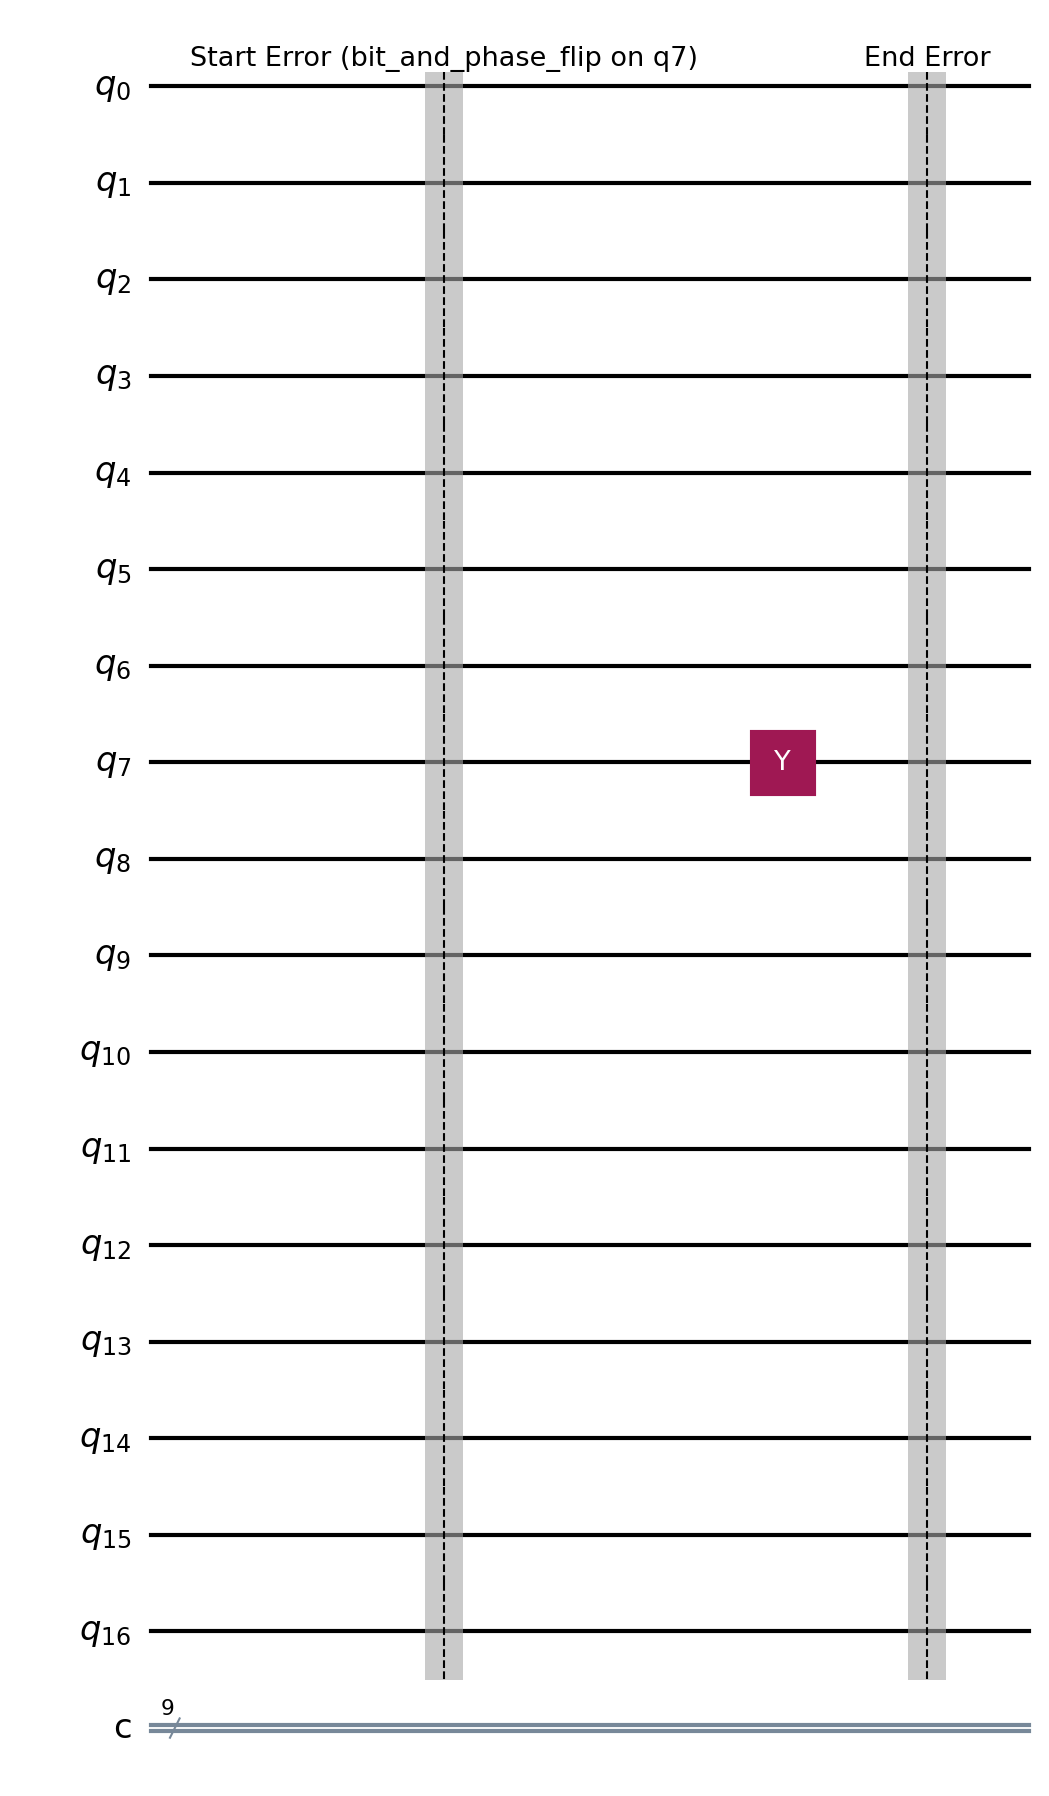


Stage 3: Error Detection and Correction


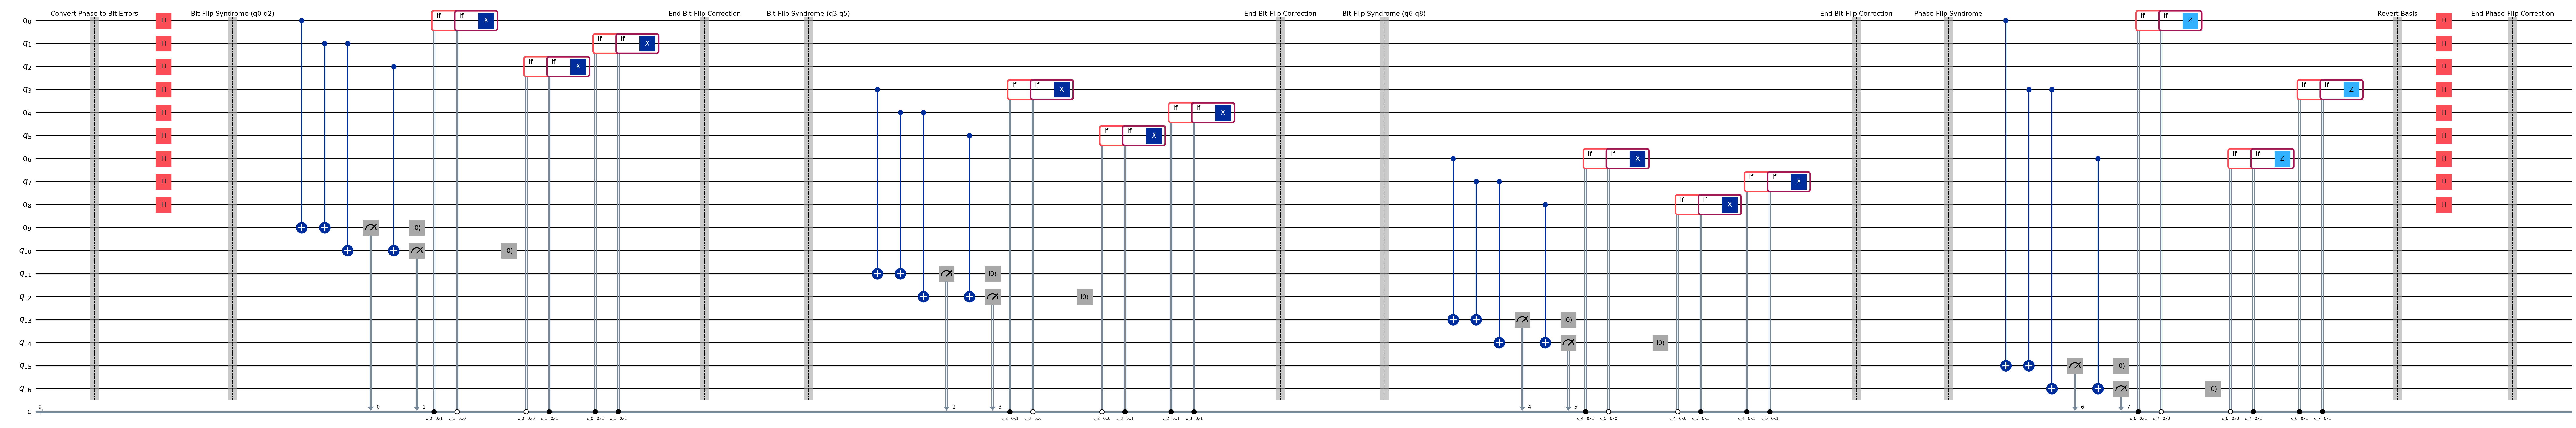


Stage 4: Decoding Circuit


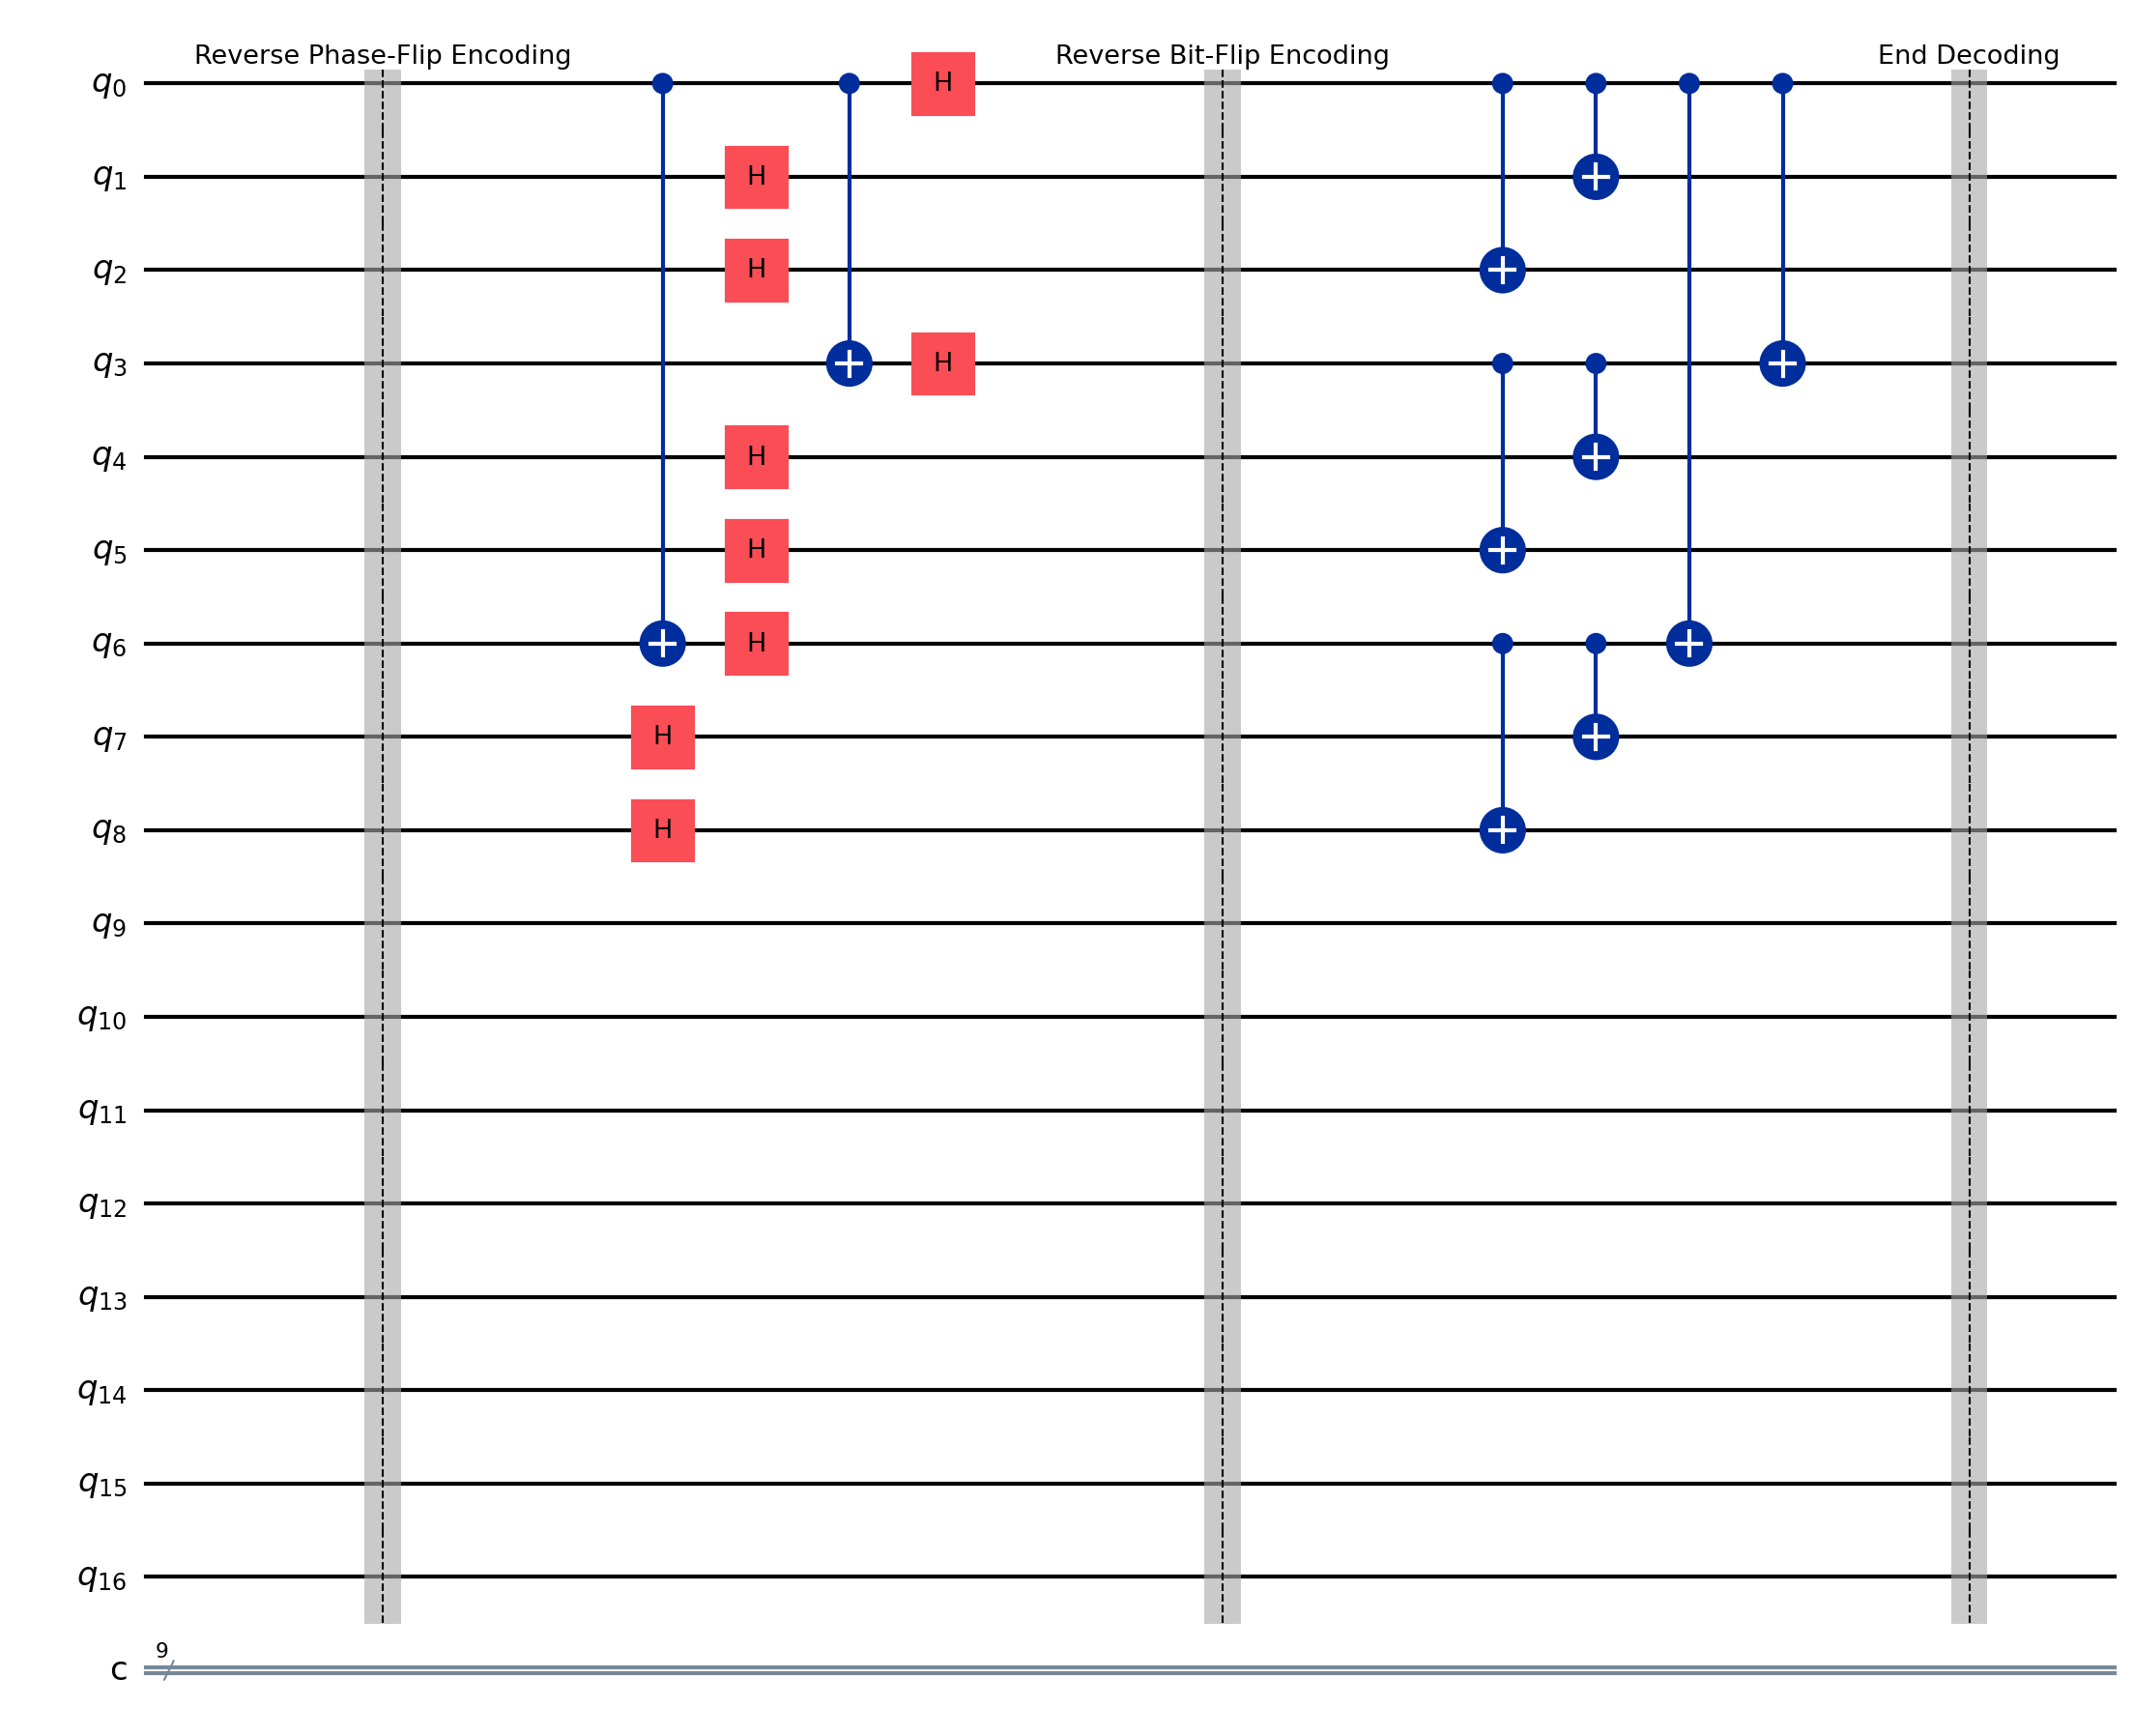


Stage 5: Final Measurement


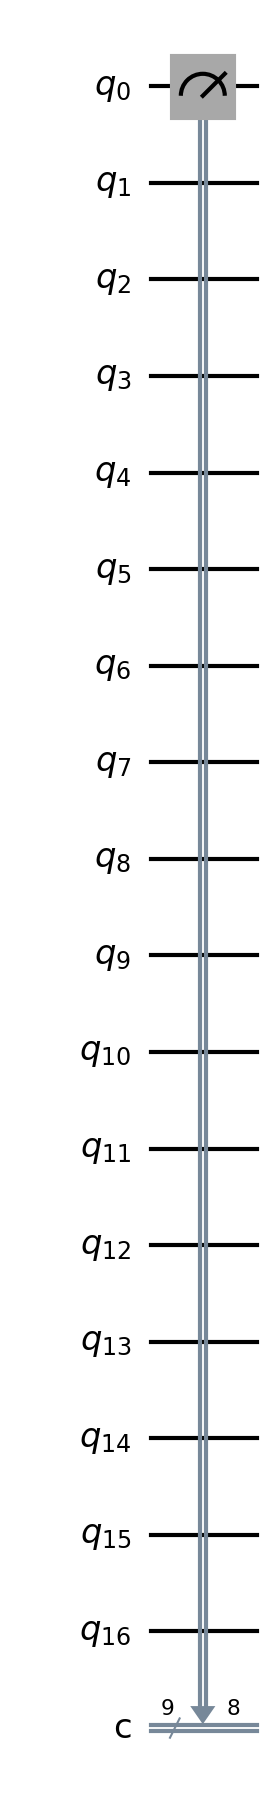

  Introducing a BIT-AND-PHASE-FLIP error on qubit 7

Measurement Results (Classical Bits, from LSB to MSB):
{'000110000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [9]:
run_shor_simulation(error_qubit=7, error_type='bit_and_phase_flip')

#### Simulation 2: BIT Flip Error on Qubit 4


Stage 1: Encoding Circuit


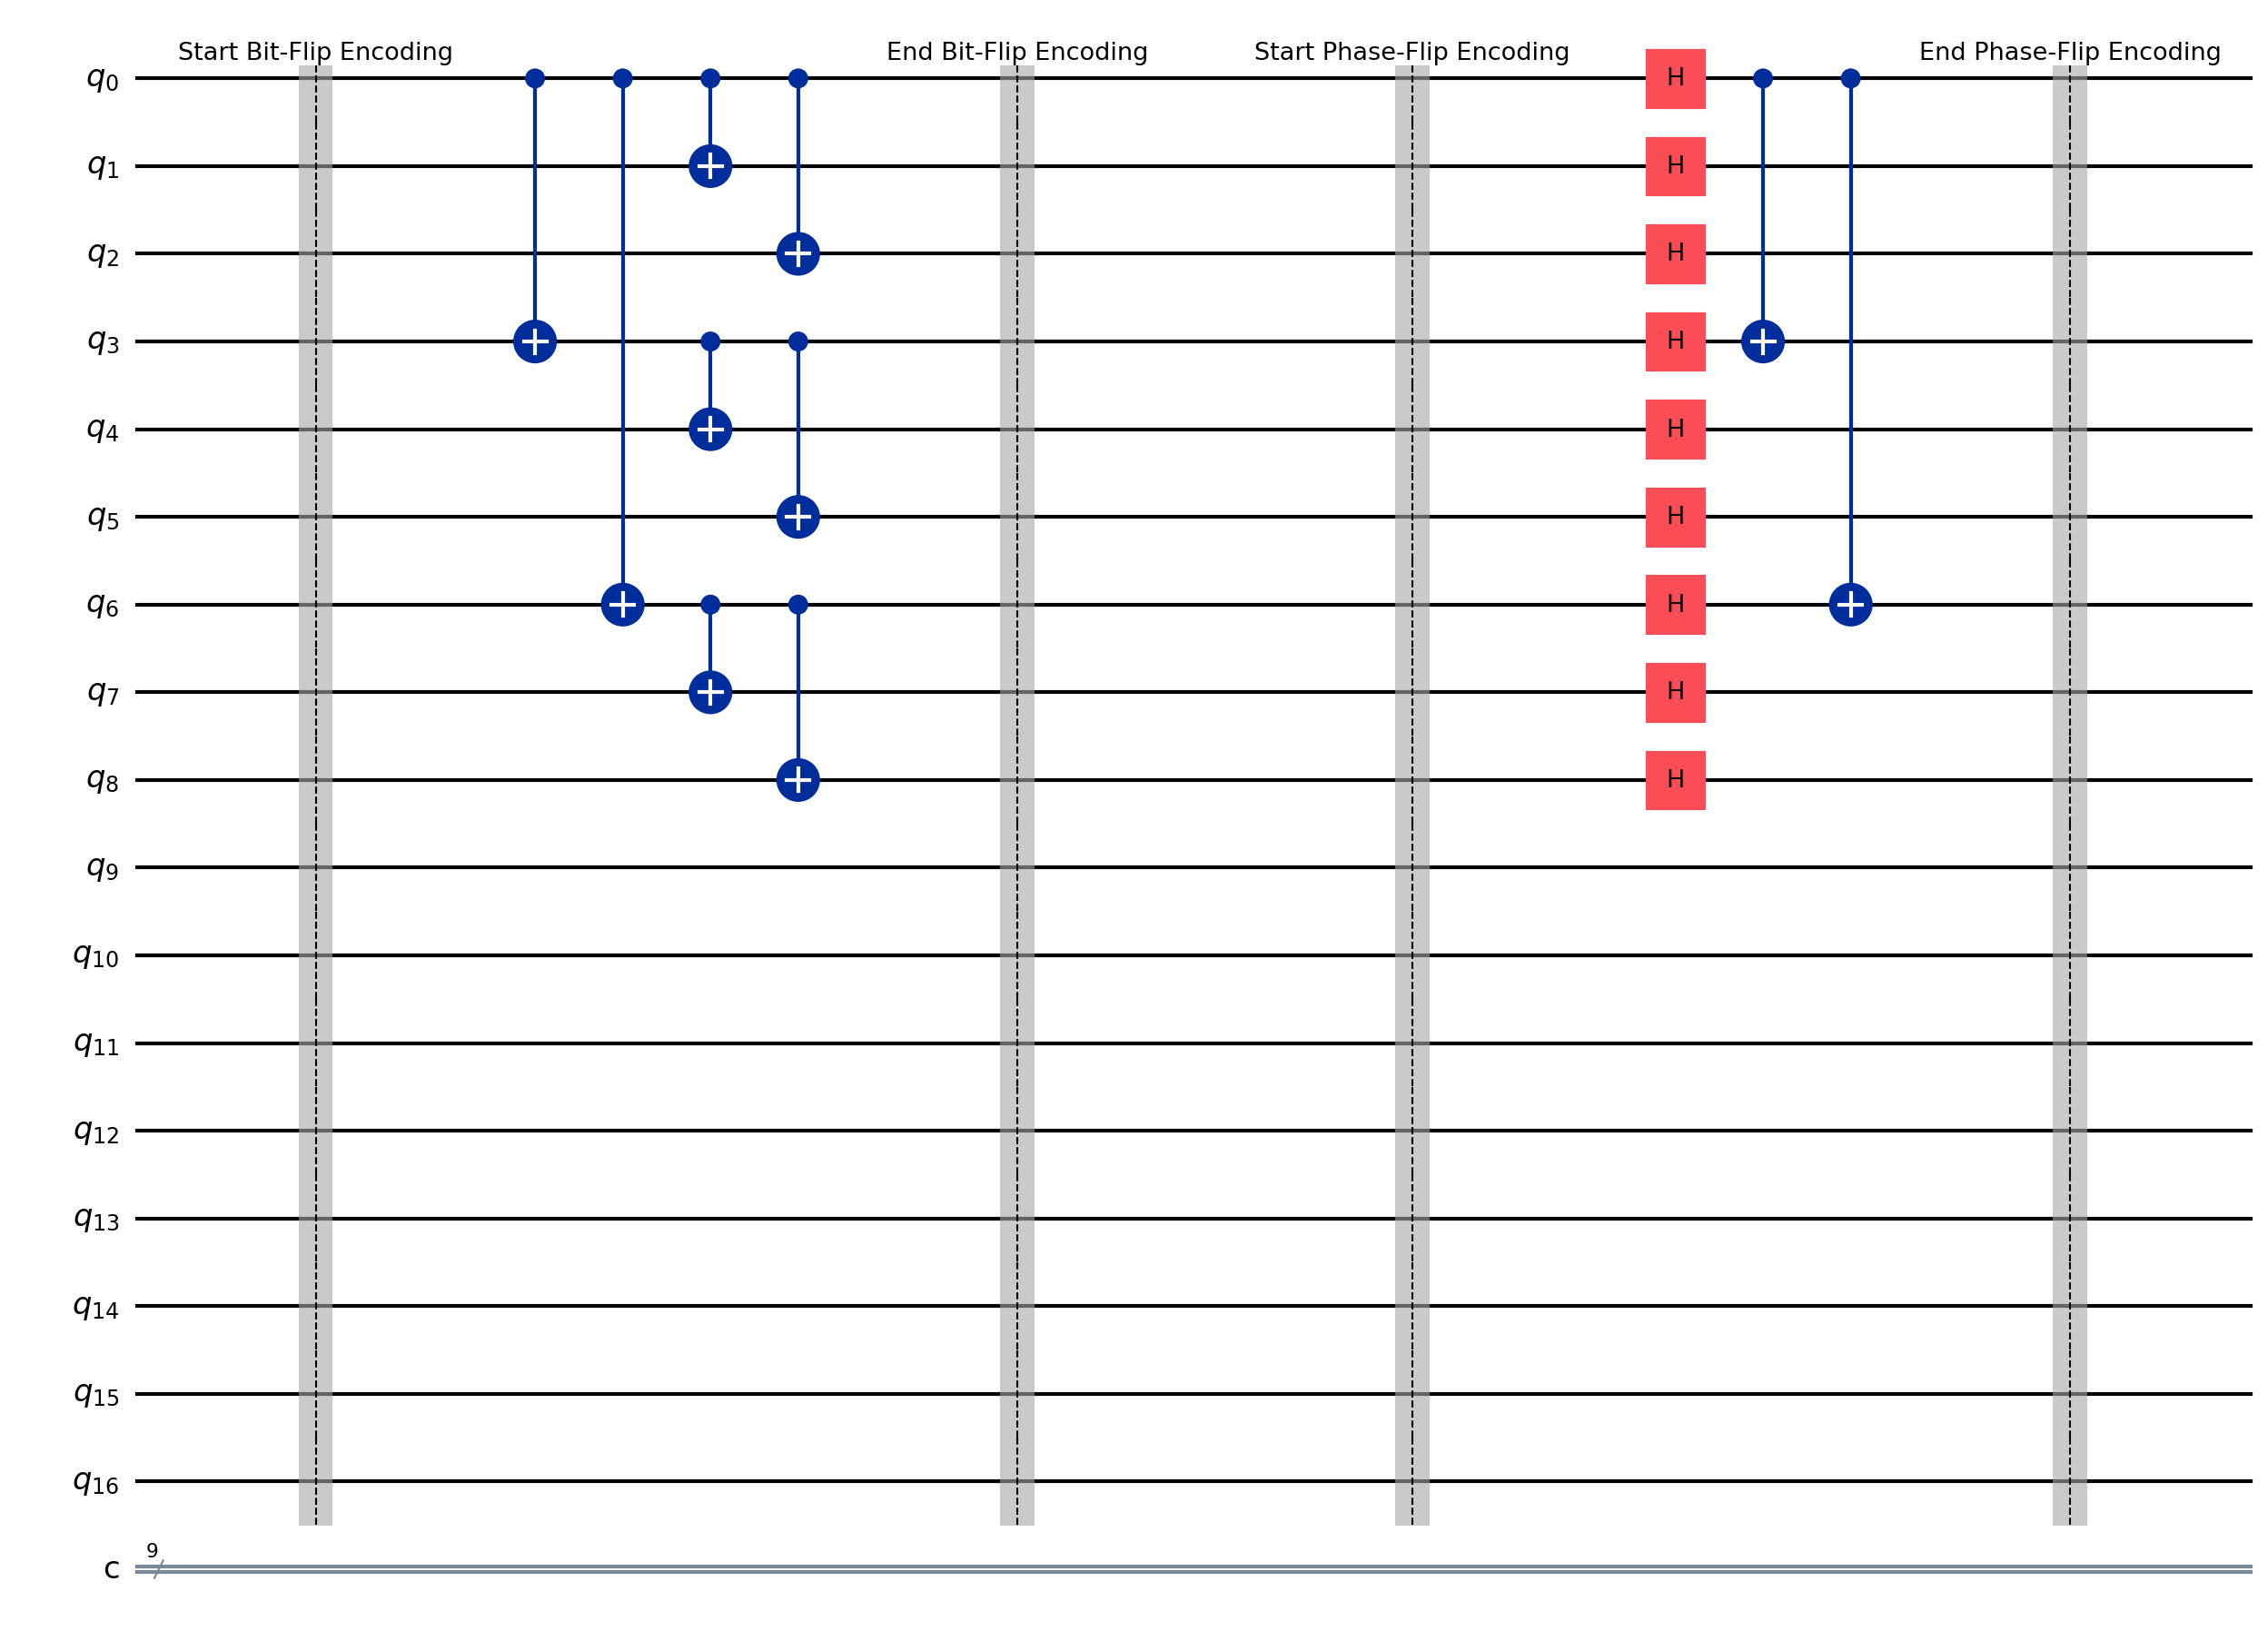


Stage 2: Error Introduction
  Introducing a BIT-FLIP error on qubit 4


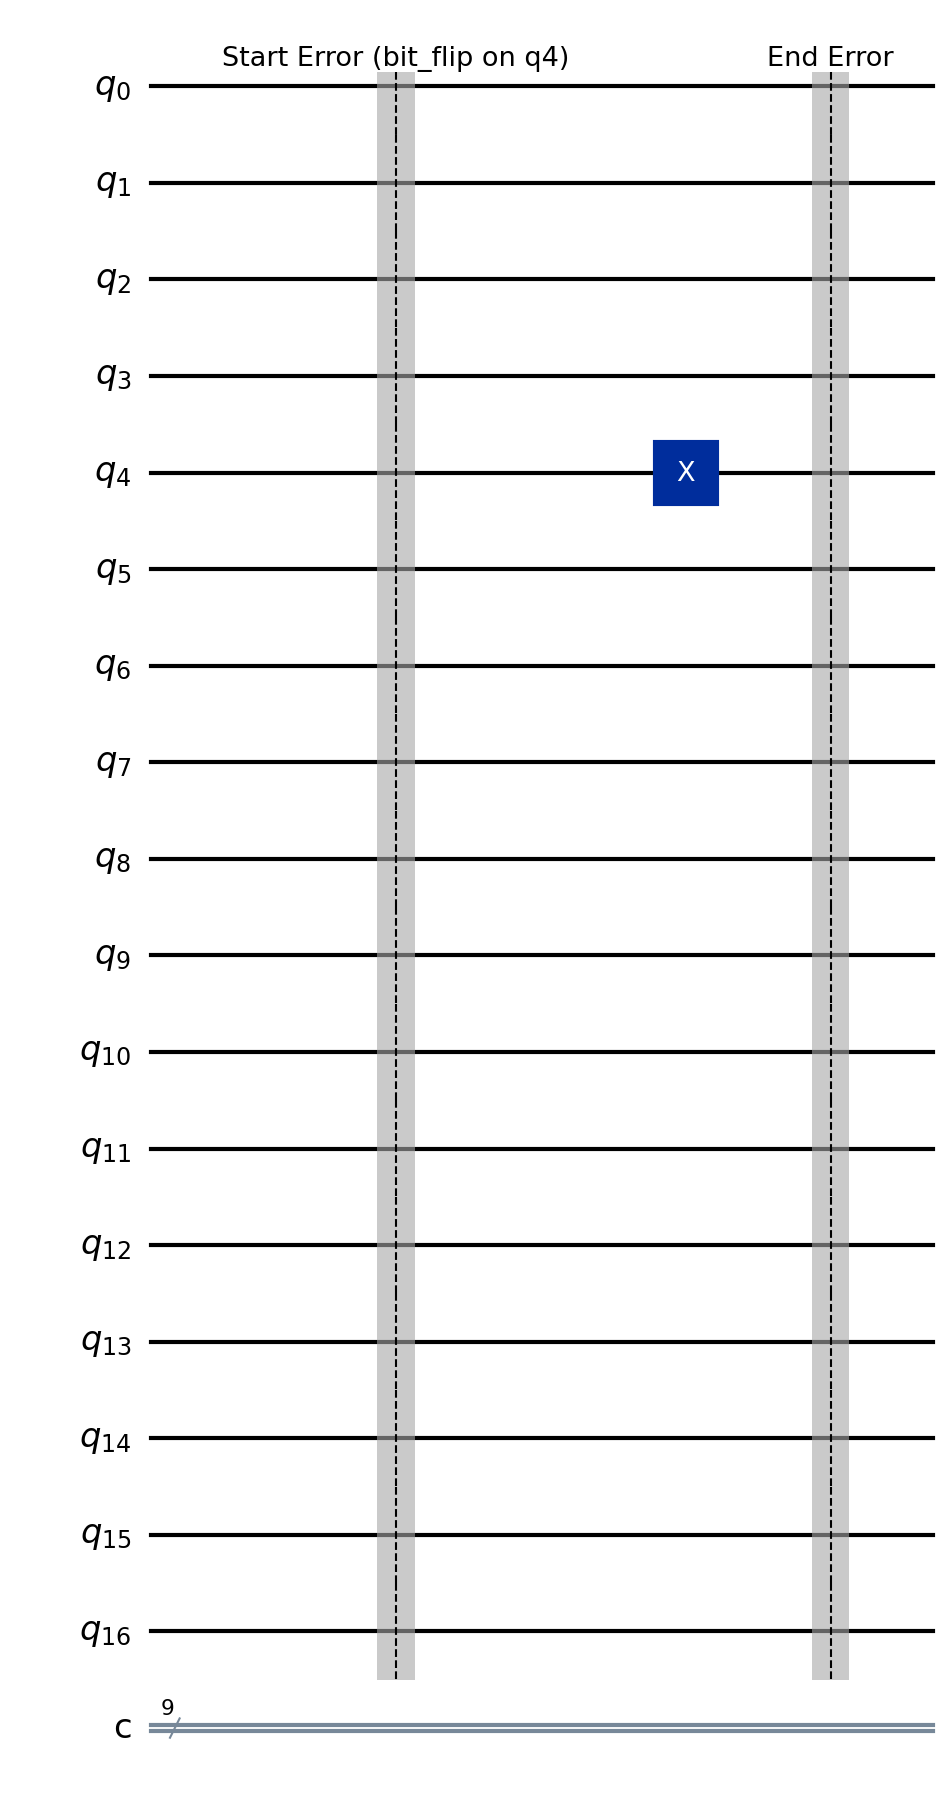


Stage 3: Error Detection and Correction


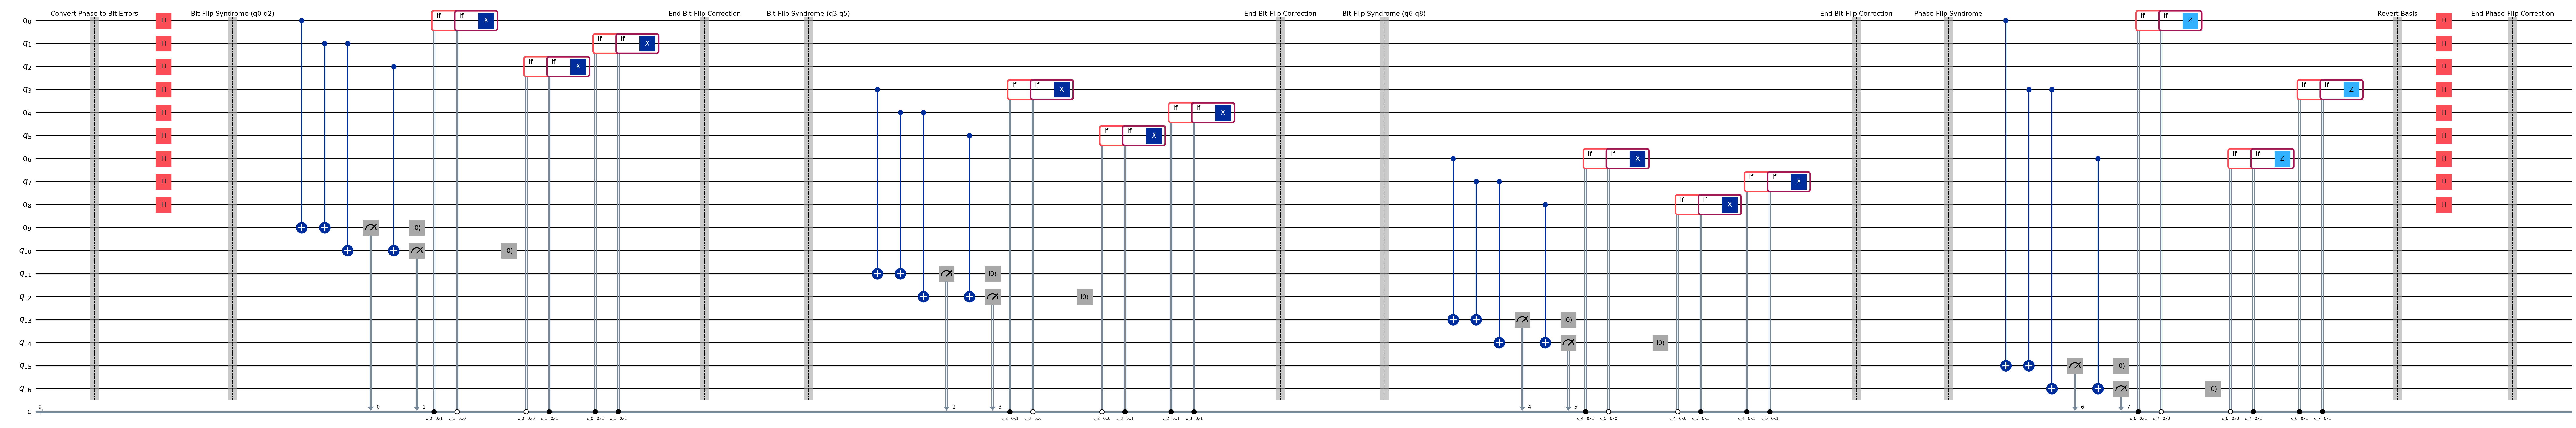


Stage 4: Decoding Circuit


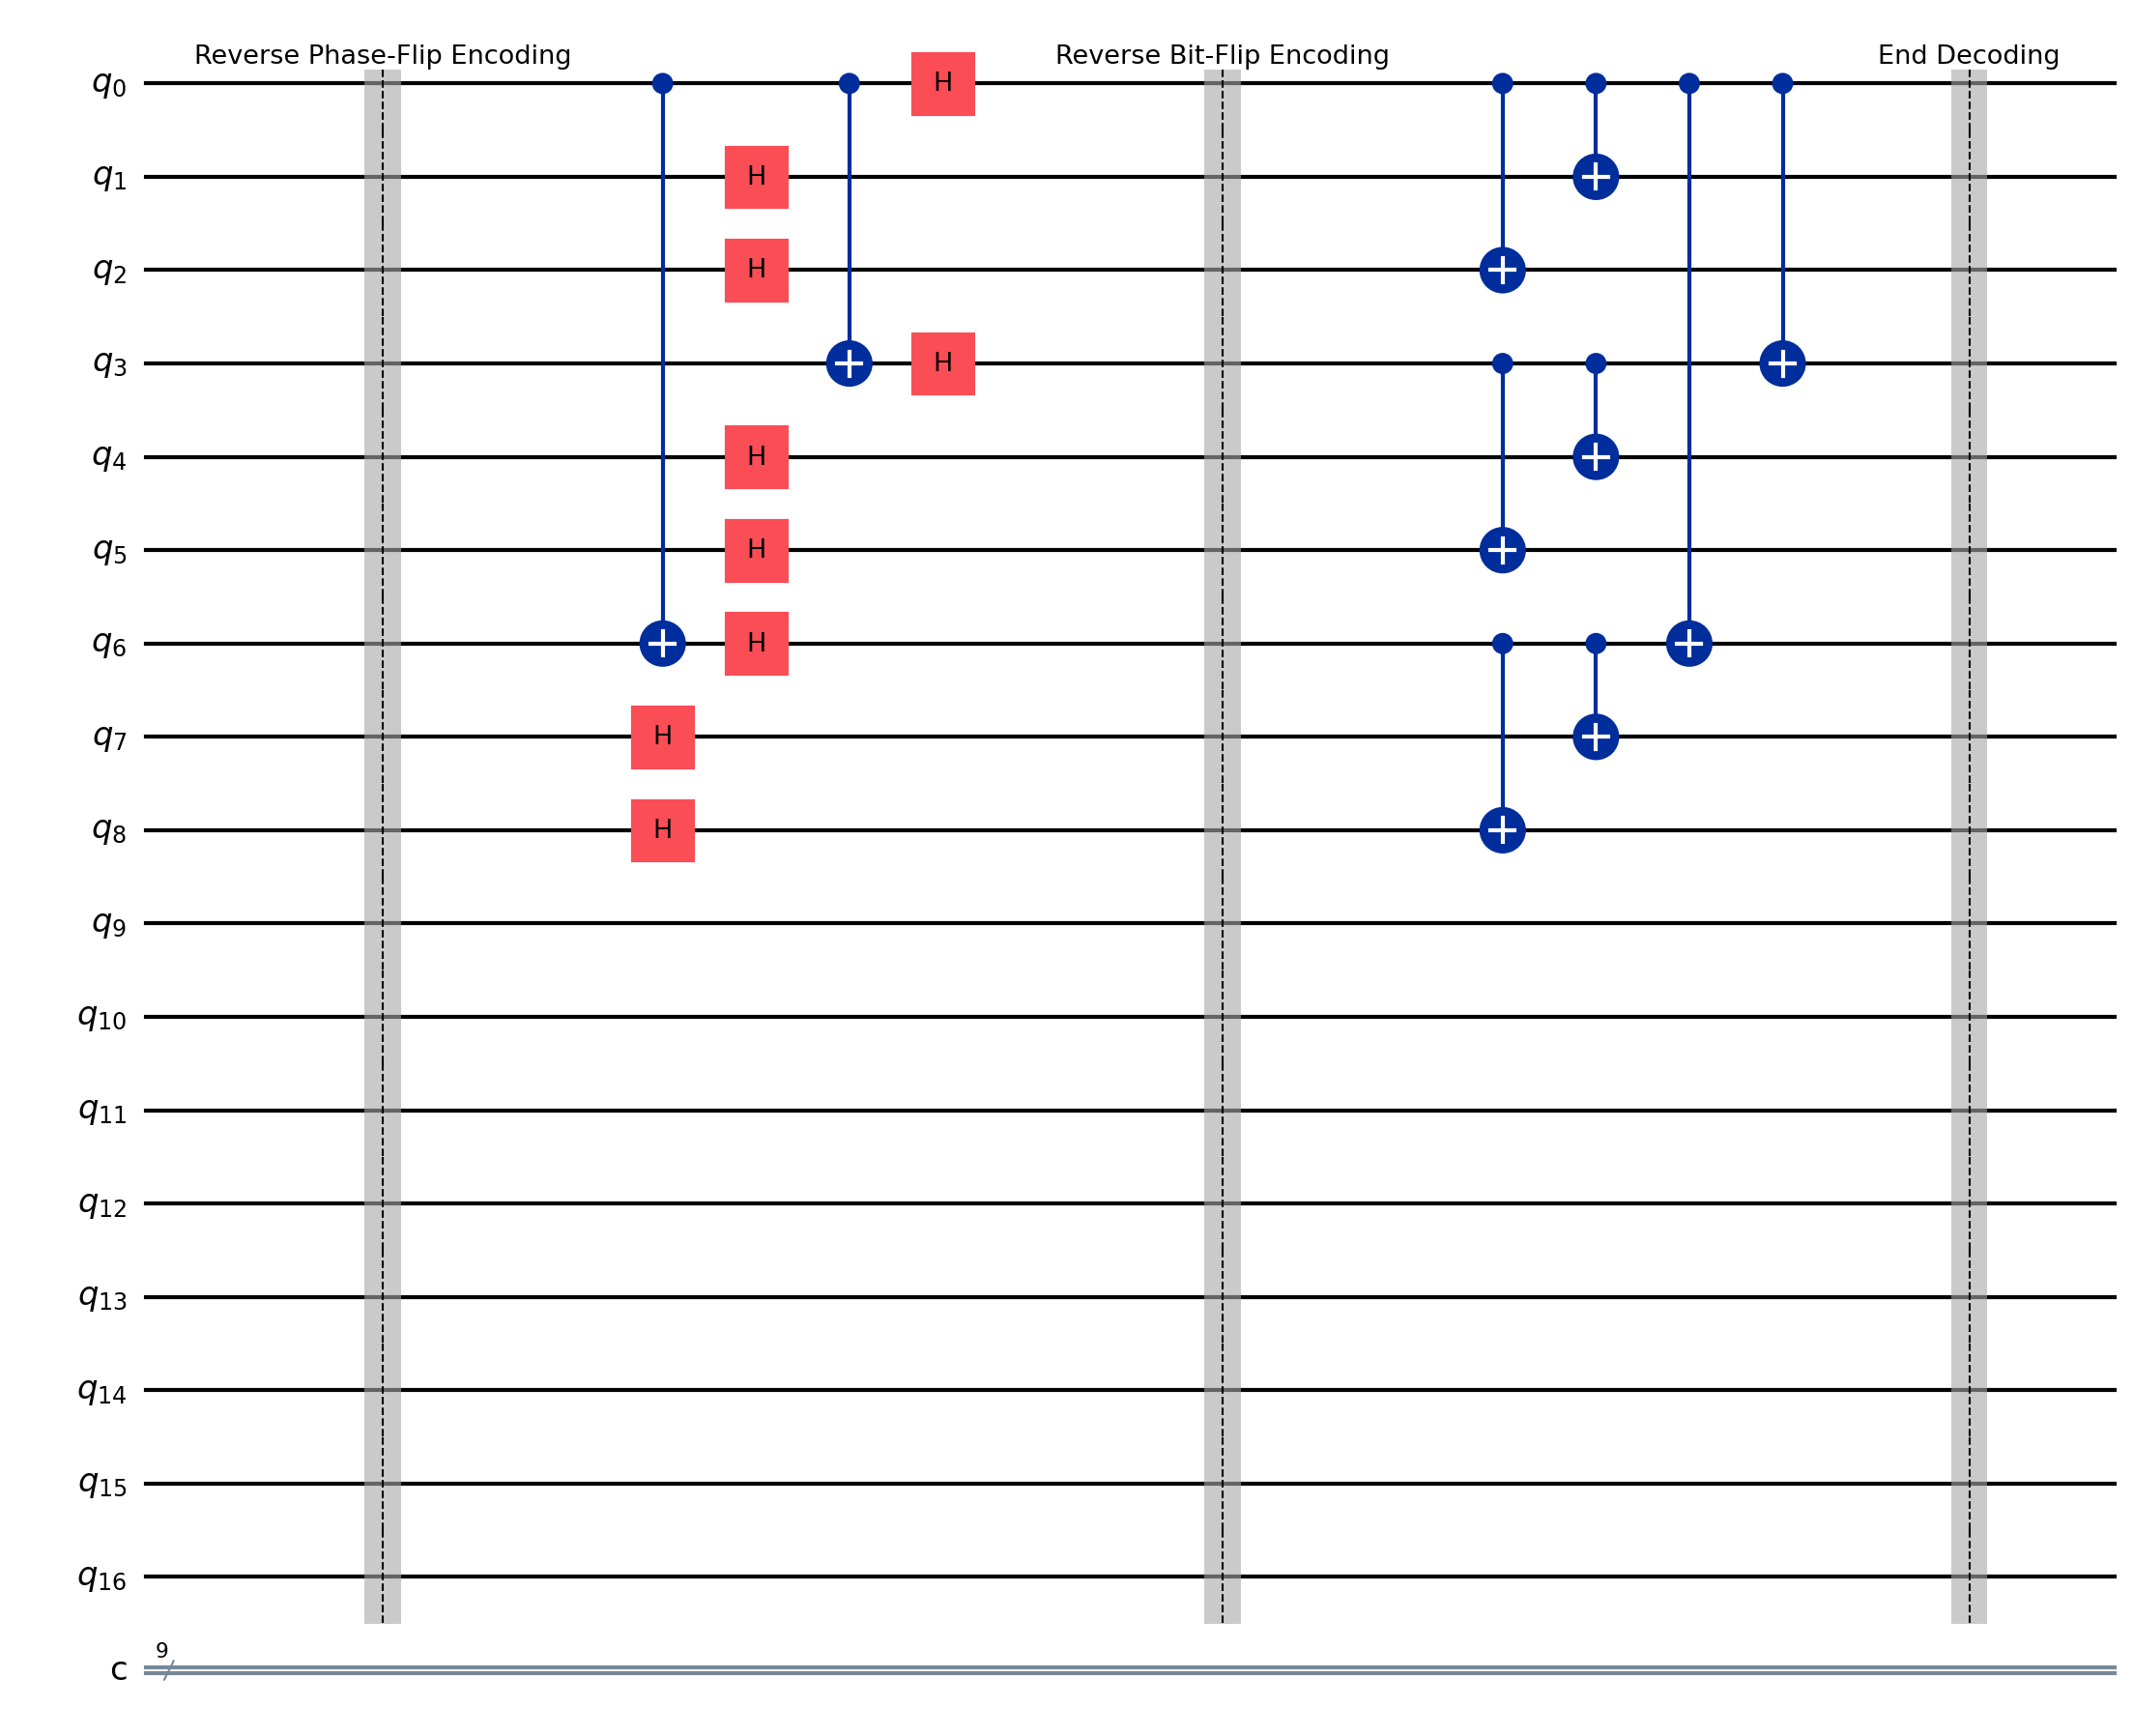


Stage 5: Final Measurement


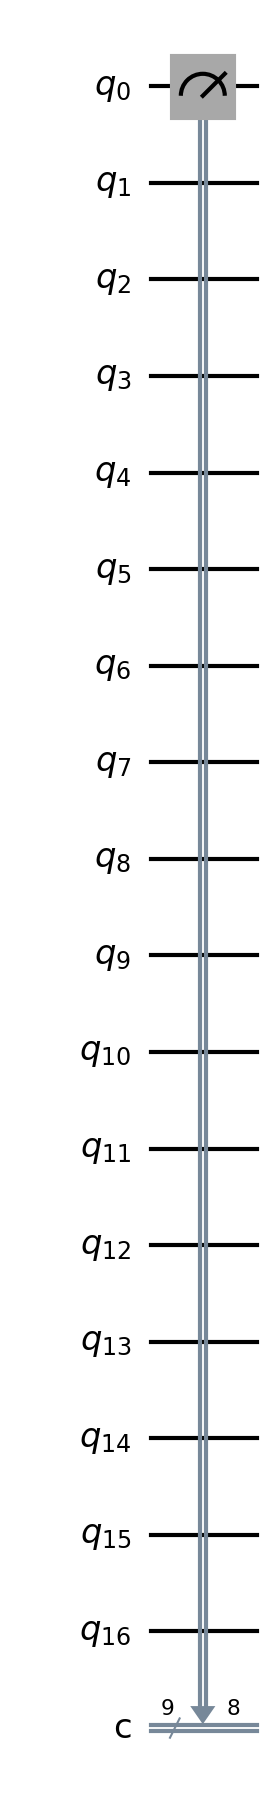

  Introducing a BIT-FLIP error on qubit 4

Measurement Results (Classical Bits, from LSB to MSB):
{'000000000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [10]:
run_shor_simulation(error_qubit=4, error_type='bit_flip')

#### Simulation 2: Phase Flip Error on Qubit 8


Stage 1: Encoding Circuit


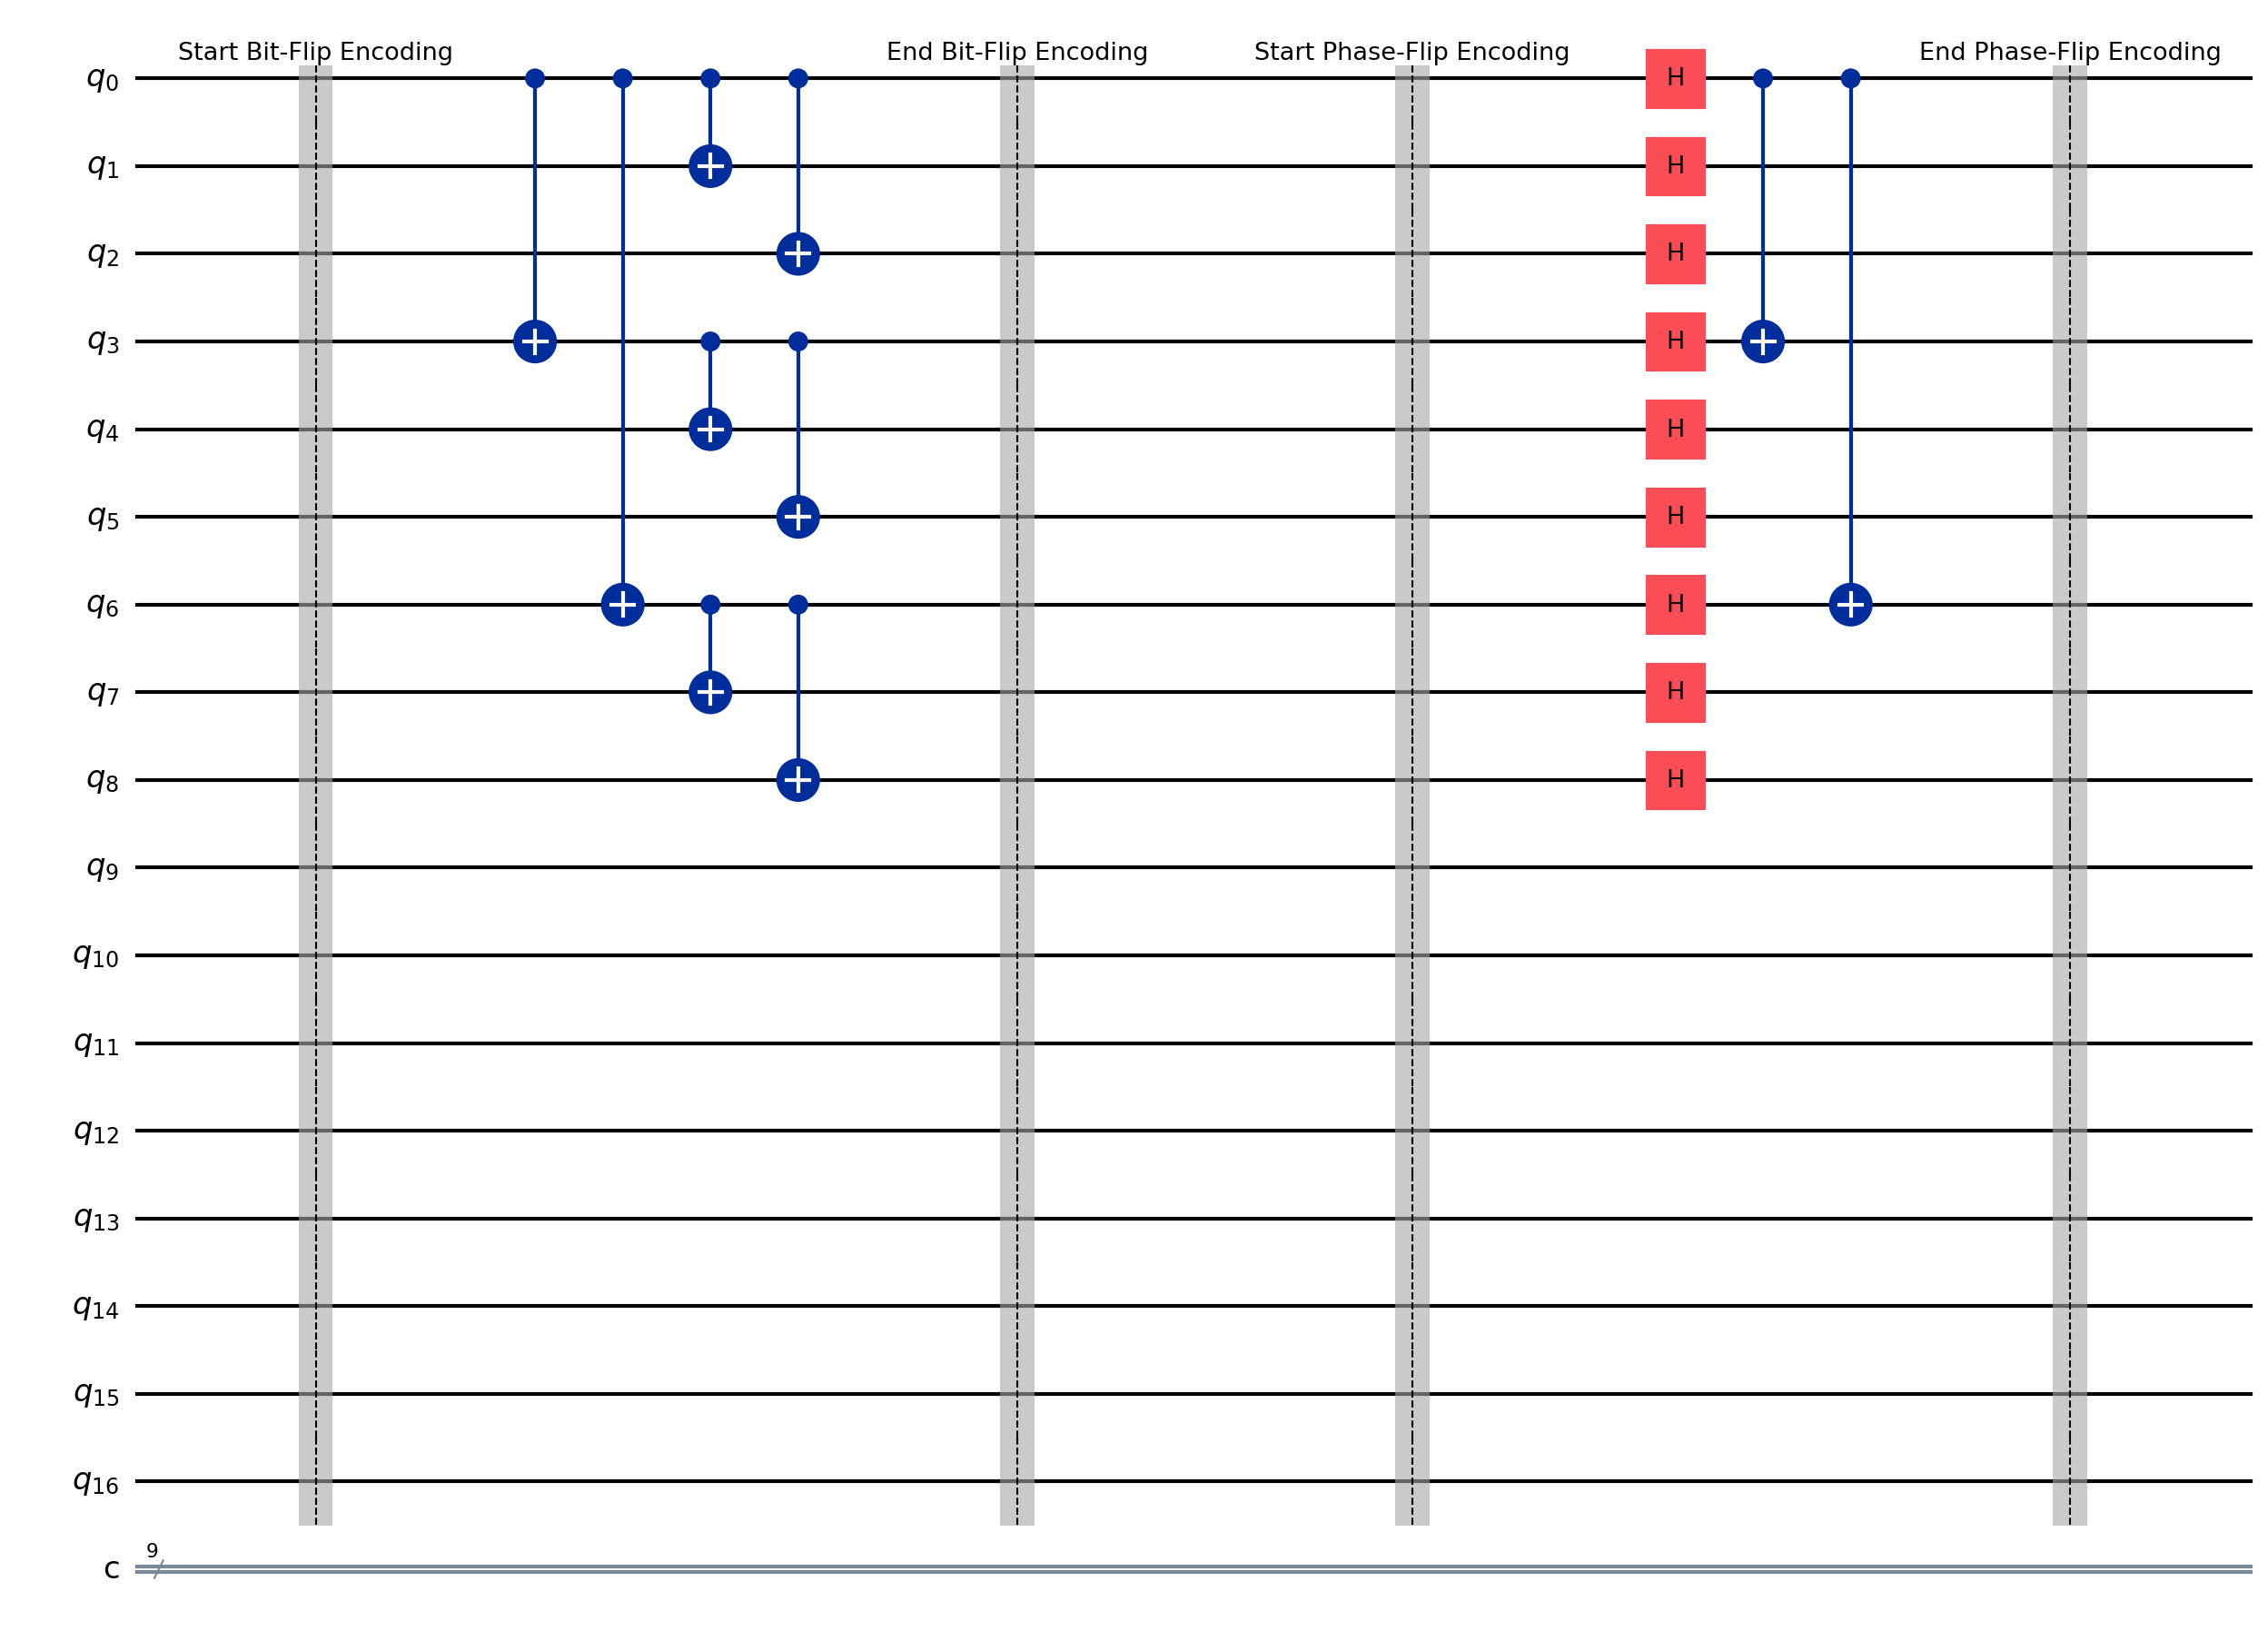


Stage 2: Error Introduction
  Introducing a PHASE-FLIP error on qubit 8


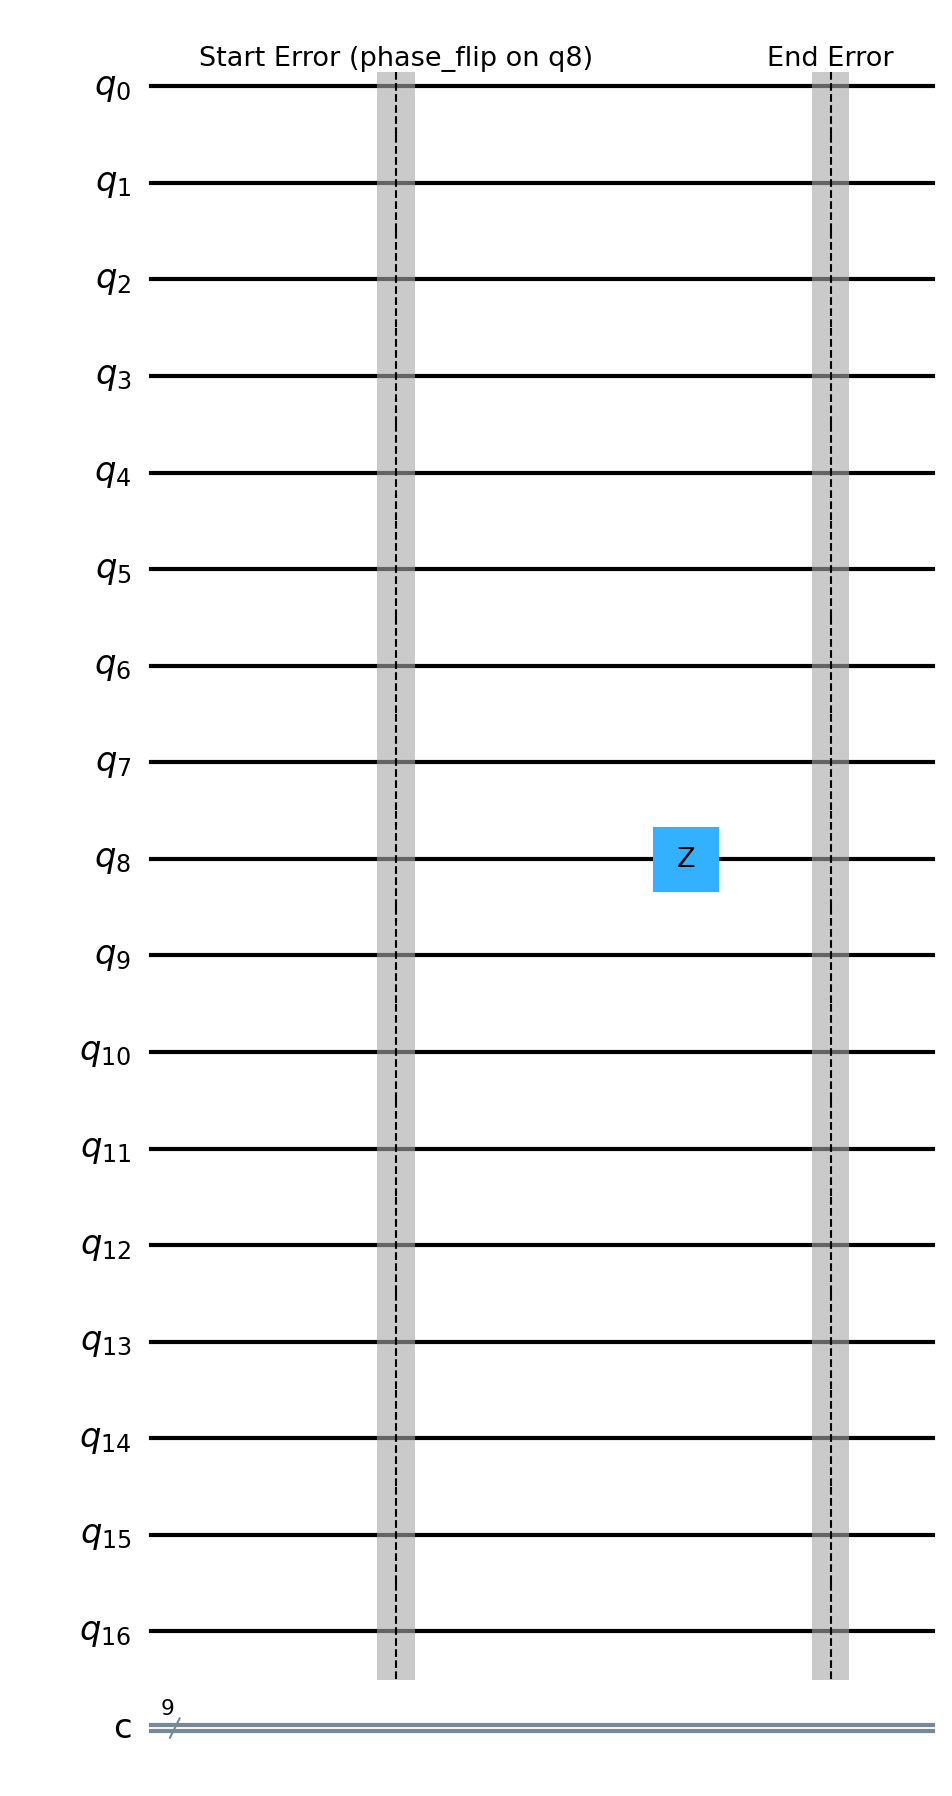


Stage 3: Error Detection and Correction


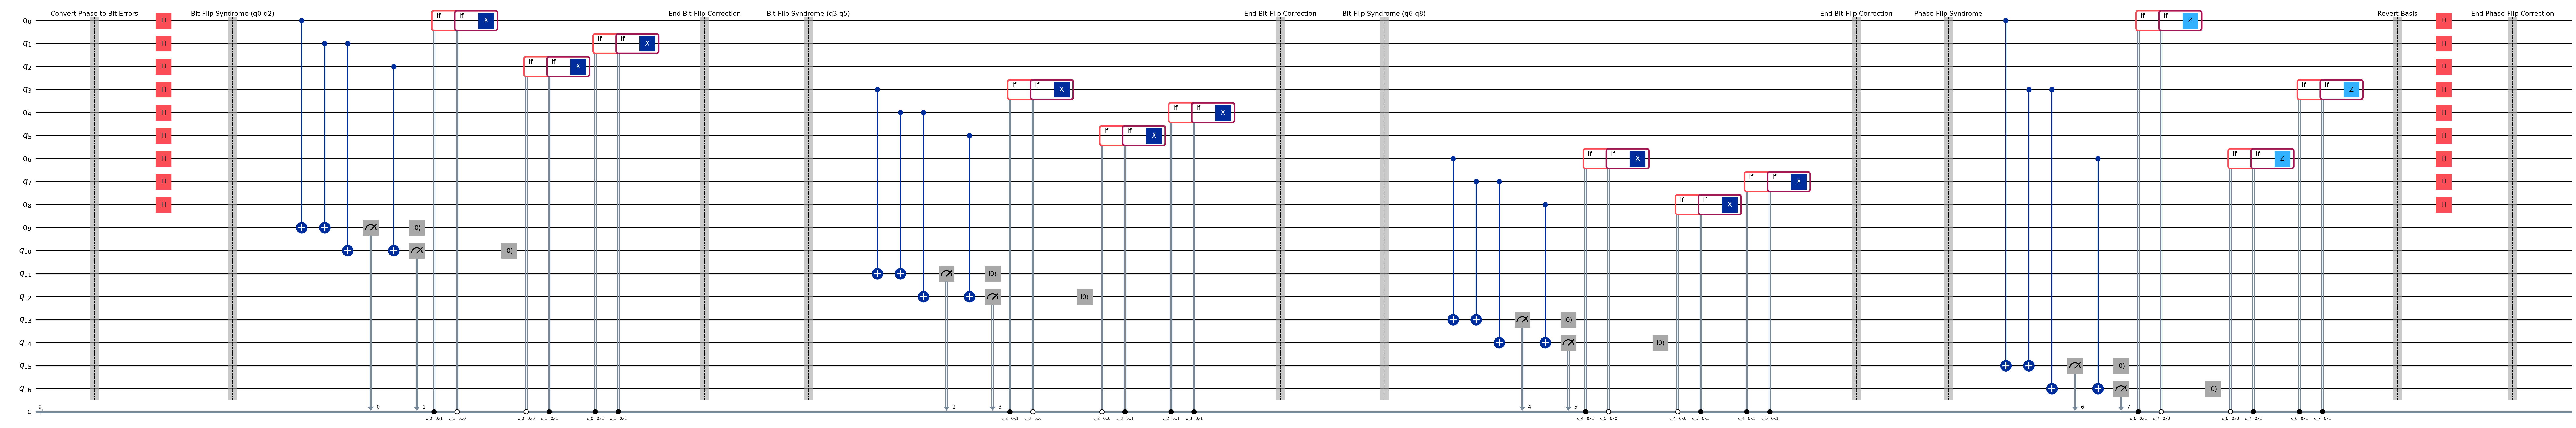


Stage 4: Decoding Circuit


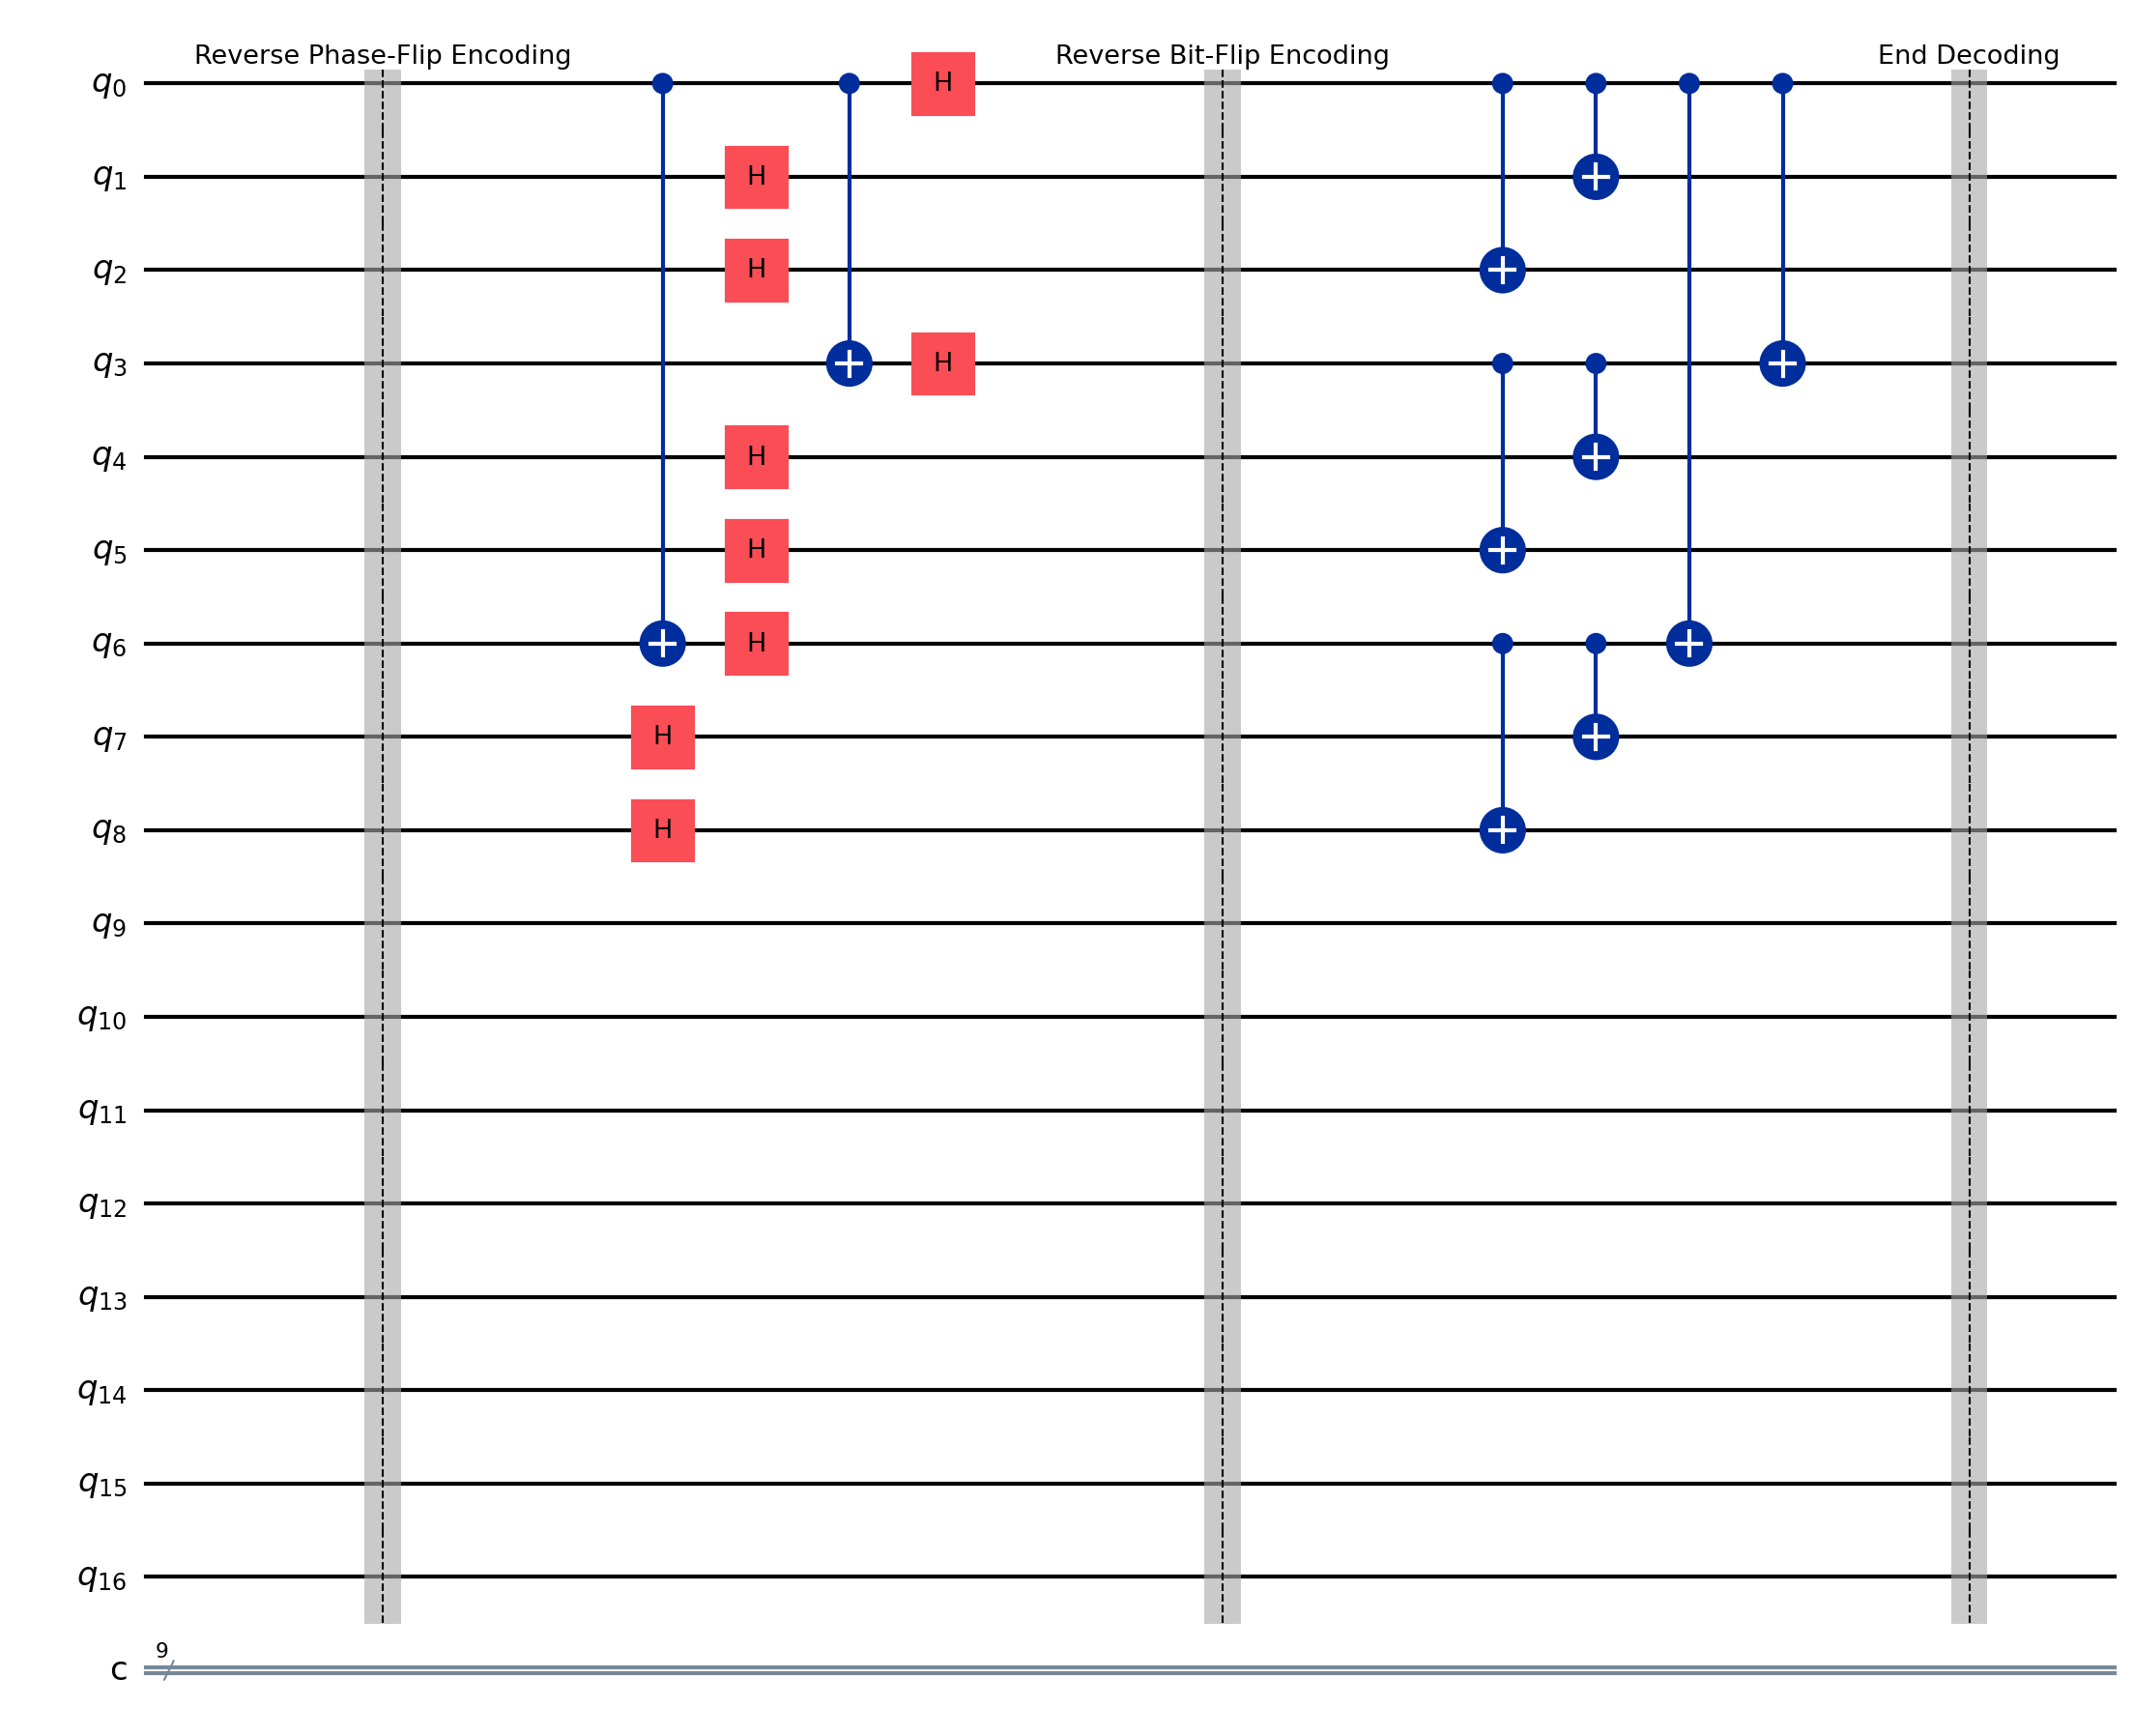


Stage 5: Final Measurement


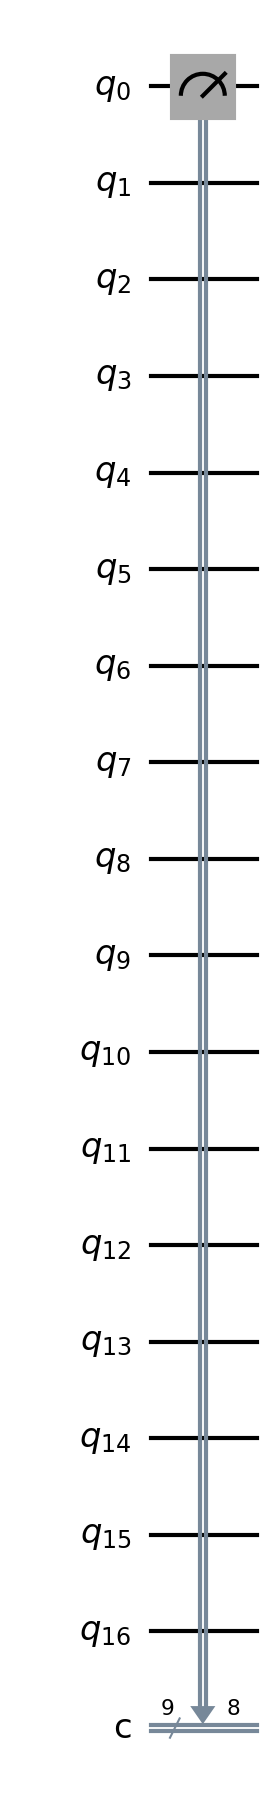

  Introducing a PHASE-FLIP error on qubit 8

Measurement Results (Classical Bits, from LSB to MSB):
{'000100000': 1024}

Decoded Logical Qubit Measurement (from c[8]):
{'0': 1024}
Success Rate (Ideal |0> state): 100.00%
Shor code successfully corrected the error!


In [11]:
run_shor_simulation(error_qubit=8, error_type='phase_flip')